In [ ]:
import sys
from beartype.typing import Dict, Any, List, Union
from pathlib import Path
from collections import defaultdict
from rich.console import Console
import gc
from beartype import beartype
import xgboost as xgb
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import polars.selectors as cs
import pickle
import shap
import glob
from datetime import datetime, timedelta
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    ndcg_score,
)
from rich.table import Table
from xgboost import XGBClassifier
from sklearn.metrics import label_ranking_average_precision_score as lr_map_score

# Globals - used throughout the notebook
console = Console()
# Path configuration
CURRENT_DIR: Path = Path("./").resolve()
DATA_DIR: Path = Path("/home/azureuser/cloudfiles/code/Users/data")
RAW_DATA_DIR: Path = Path("/home/azureuser/cloudfiles/code/Users/data/raw")
PACKAGE_DIR: Path = Path("/home/azureuser/cloudfiles/code/Users/src/").resolve()

# Add our package directory to Python's path to allow imports
# WARN This makes local modules accessible without installation
_ = sys.path.insert(0, str(PACKAGE_DIR))

# Import database querying utilities from local package
from _queries.query_database import (
    safe_query_database,  # Query with error handling
    CONNECTION_STRING_CONFIG,  # Database connection configuration
    DEFAULT_QUERY_BACKEND_CONFIG,  # Default settings for query backend
)

_ = console.print(f"CURRENT_DIR: {CURRENT_DIR}")

In [ ]:
@beartype
def scan_most_recent_parquet(directory: Path, pattern: str) -> pl.LazyFrame:
    """
    Scan the most recent parquet file matching a pattern.

    Parameters
    ----------
    directory : pathlib.Path
        Directory to search in
    pattern : str
        Glob pattern to match files

    Returns
    -------
    polars.LazyFrame
        LazyFrame from scanning the most recent matching file
    """
    files = sorted(list(directory.glob(pattern)))
    most_recent = files[-1] if files else None
    if most_recent is None:
        raise FileNotFoundError(
            f"No files matching pattern {pattern} found in {directory}"
        )
    return pl.scan_parquet(most_recent)

## Aggregate service data into weekly snapshots per client & Feature Engineering

In [ ]:
# NOTE weekly aggregation of the event stream
# Load the event-level data
eng_lf = scan_most_recent_parquet(
    RAW_DATA_DIR, "initial_modeling_data.parquet"
)

# First and last event per client
client_event_bounds = (
    eng_lf.group_by("client_id_joint")
    .agg([
        pl.col("event_date").min().alias("start_date"),
        pl.col("event_date").max().alias("end_date"),
    ])
    .collect()
)

# Create full grid of client_id_joint x week_start
client_weeks = []
for row in client_event_bounds.iter_rows(named=True):
    weeks = pl.date_range(
        start=row["start_date"],
        end=row["end_date"],
        interval="1w",
        eager=True
    ).to_frame("event_date")
    weeks = weeks.with_columns(pl.lit(row["client_id_joint"]).alias("client_id_joint"))
    client_weeks.append(weeks)
client_weeks_df = pl.concat(client_weeks)

# One-hot encode categorical columns
categorical_columns = [
    "employee_category_supertype",
    "funder_level",
    "billing_service_type",
    "direct_indirect",
    "status_reason_category",
    "service_type_supertype"
]

dummies_df = eng_lf.collect().to_dummies(columns=categorical_columns)
# Ensure event_date and client_id_joint present
for col in ("event_date", "client_id_joint"):
    if col not in dummies_df.columns:
        dummies_df = dummies_df.with_columns(eng_lf.collect().select(col))

# Weekly dummy counts
dummy_cols = [c for c in dummies_df.columns if any(c.startswith(f"{cat}_") for cat in categorical_columns)]
weekly_dummies = (
    dummies_df.lazy()
    .group_by_dynamic(
        index_column="event_date",
        group_by="client_id_joint",
        every="1w",
        period="1w",
        start_by="datapoint",
        closed="left"
    )
    .agg([pl.sum(col).alias(col) for col in dummy_cols])
    .collect()
)

# Weekly numeric aggregates
weekly_agg = (
    eng_lf.group_by_dynamic(
        index_column="event_date",
        group_by="client_id_joint",
        every="1w",
        period="1w",
        start_by="datapoint",
        closed="left"
    )
    .agg([
        pl.sum("duration").alias("duration_sum"),
        pl.sum("billable_duration_minutes").alias("billable_duration_sum"),
        pl.sum("payable_duration_minutes").alias("payable_duration_sum"),
        pl.sum("billable_duration_minutes_minus_duration_minutes").alias("billable_minus_duration_sum"),
        pl.sum("amount").alias("amount_sum"),
        pl.sum("statutory_billing_rate").alias("statutory_billing_sum"),
        # pl.col("duration").cast(pl.Float64).mean().alias("duration_mean"),
        # pl.col("billable_duration_minutes").cast(pl.Float64).mean().alias("billable_duration_mean"),
        # pl.col("payable_duration_minutes").cast(pl.Float64).mean().alias("payable_duration_mean"),
        # pl.col("billable_duration_minutes_minus_duration_minutes").cast(pl.Float64).mean().alias("billable_minus_duration_mean"),
        # pl.col("amount").cast(pl.Float64).mean().alias("amount_mean"),
        # pl.col("statutory_billing_rate").cast(pl.Float64).mean().alias("statutory_billing_mean"),
        pl.sum("number_of_visits").alias("visits_sum"),
        pl.col("target").unique().alias("target")
    ])
    .collect()
)

# Combine scaffold, aggregates, and dummies
weekly_complete = (
    client_weeks_df
    .join(weekly_agg, on=["client_id_joint", "event_date"], how="left")
    .join(weekly_dummies, on=["client_id_joint", "event_date"], how="left")
    .sort(["client_id_joint", "event_date"])
)

# Impute missing values
weekly_imputed = (
    weekly_complete.with_columns([
        pl.col("duration_sum").fill_null(0),
        pl.col("billable_duration_sum").fill_null(0),
        pl.col("payable_duration_sum").fill_null(0),
        pl.col("billable_minus_duration_sum").fill_null(0),
        pl.col("amount_sum").fill_null(0),
        pl.col("statutory_billing_sum").fill_null(0),
        # pl.col("duration_mean").fill_null(strategy="forward"),
        # pl.col("billable_duration_mean").fill_null(strategy="forward"),
        # pl.col("payable_duration_mean").fill_null(strategy="forward"),
        # pl.col("billable_minus_duration_mean").fill_null(strategy="forward"),
        # pl.col("amount_mean").fill_null(strategy="forward"),
        # pl.col("statutory_billing_mean").fill_null(strategy="forward"),
        pl.col("visits_sum").fill_null(0),
        pl.col("target").fill_null(pl.Series([[]] * weekly_complete.height, dtype=pl.List(pl.Utf8))),
        *[pl.col(col).fill_null(0) for col in dummy_cols]
    ])
    .select([
        "client_id_joint",
        "event_date",
        *[c for c in weekly_complete.columns if c not in ["client_id_joint", "event_date", "target"]],
        "target"
    ])
)

# Add past-4-week rolling features per client
# Cast to numeric types to avoid decimal errors
weekly_imputed = weekly_imputed.with_columns(
    [pl.col(col).cast(pl.Float64).alias(col) for col in [
        "amount_sum", "duration_sum", "billable_duration_sum", "payable_duration_sum", "visits_sum"
    ]]
)

# Rolling expressions with updated min_samples for both numeric and dummy
rolling_exprs = [
    # Numeric sums & means
    pl.col("amount_sum").shift(1).rolling_sum(4, min_samples=1).over("client_id_joint").fill_null(0).alias("amount_4_week_sum"),
    pl.col("duration_sum").shift(1).rolling_sum(4, min_samples=1).over("client_id_joint").fill_null(0).alias("duration_4_week_sum"),
    pl.col("billable_duration_sum").shift(1).rolling_sum(4, min_samples=1).over("client_id_joint").fill_null(0).alias("billable_duration_4_week_sum"),
    pl.col("payable_duration_sum").shift(1).rolling_sum(4, min_samples=1).over("client_id_joint").fill_null(0).alias("payable_duration_4_week_sum"),
    pl.col("visits_sum").shift(1).rolling_sum(4, min_samples=1).over("client_id_joint").fill_null(0).alias("visits_4_week_sum"),
    *[
        pl.col(col).cast(pl.UInt32)
        .shift(1)
        .rolling_sum(4, min_samples=1)
        .over("client_id_joint")
        .fill_null(0)
        .alias(f"{col}_count_4_week_sum")
        for col in dummy_cols
    ]
]

weekly_features = weekly_imputed.with_columns(rolling_exprs)

# Save the enriched weekly features
weekly_features.write_parquet("output/weekly_modeling_data_with_4w.parquet")
weekly_features.head(10)

## Create the binary target

In [ ]:
# NOTE turn weekly event stream into weekly new-service binary target by checking is service was used in the past 4 weeks

# Load the weekly features
weekly = pl.read_parquet("output/hcs_weekly_modeling_data_with_4w.parquet")

# Build per-client, per-week service lists
weekly_services = (
    weekly
    .select(["client_id_joint", "event_date", "target"])
    .explode("target")
    .group_by(["client_id_joint", "event_date"])
    .agg(
        pl.col("target").unique().alias("services")
    )
    .sort(["client_id_joint", "event_date"])
    .with_columns(
        # Previous week's services for each client
        pl.col("services").shift(1).over("client_id_joint").alias("prev_services_4w")
    )
)

# Use group_by_dynamic to look back 4 weeks at weekly intervals
prev4 = (
    weekly_services
    .lazy()
    .group_by_dynamic(
        index_column="event_date",
        every="7d",       # emit a window each week
        period="28d",      # span of each window is 4 weeks
        offset="-28d",
        group_by="client_id_joint",
        start_by="window",
        closed="left"      # exclude the current week
    )
    .agg(
        # explode each week's service lists into individual entries then unique across the 4-week window
        pl.col("prev_services_4w")
          .explode()
          .unique()
          .alias("prev_services_4w")
    )
    .collect()
)

# Join previous 4-week history back
ws = weekly_services.join(
    prev4,
    on=["client_id_joint", "event_date"],
    how="left"
)

# Compute new_service_flag using a Python loop for subset testing
flags = []
for services, prev in zip(ws["services"], ws["prev_services_4w"]):
    # Treat None as empty set
    services_set = set(services) if services is not None else set()
    prev_set = set(prev) if prev is not None else set()
    if services_set.issubset(prev_set):
        flags.append(0)
    else:
        flags.append(1)

ws = ws.with_columns([
    pl.Series("new_service_flag", flags)
])

# Attach binary flag back onto original weekly data
binary_flag = ws.select(["client_id_joint", "event_date", "new_service_flag"])

weekly_binary = (
    weekly
    .drop("target")
    .join(binary_flag, on=["client_id_joint", "event_date"], how="left")
    .with_columns([pl.col("new_service_flag").alias("target")])
    .drop("new_service_flag")
)

# Save and peek
weekly_binary.write_parquet("output/hcs_weekly_bc_data_with_4w.parquet")
weekly_binary.head(10)

## Baseline Modeling

In [ ]:
from pathlib import Path
from typing import Final, Tuple, List
import polars as pl
import numpy as np
import pickle
import matplotlib.pyplot as plt
from beartype import beartype
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, average_precision_score, precision_recall_curve, roc_curve
import shap
from datetime import datetime, date

# Paths
DATA_PATH: Final[Path] = Path("output/weekly_bc_data_with_4w.parquet")
TRAIN_DF_PATH: Final[Path] = Path("output/train_df_bc_weekly.parquet")
TEST_DF_PATH: Final[Path] = Path("output/test_df_bc_weekly.parquet")
MODEL_PATH: Final[Path] = Path("output/xgb_bc_weekly.pkl")
SPLIT_DATE_STR: Final[str] = "2024-09-01"
SPLIT_DATE: Final[date] = datetime.strptime(SPLIT_DATE_STR, "%Y-%m-%d").date()

@beartype
def save_splits() -> None:
    df = pl.read_parquet(DATA_PATH)

    # Ensure event_date is Date type
    if df["event_date"].dtype == pl.Utf8:
        df = df.with_columns(
            pl.col("event_date").str.strptime(pl.Date, "%Y-%m-%d").alias("event_date")
        )
    else:
        df = df.with_columns(
            pl.col("event_date").cast(pl.Date).alias("event_date")
        )

    train_df = df.filter(pl.col("event_date") < SPLIT_DATE)
    test_df  = df.filter(pl.col("event_date") >= SPLIT_DATE)

    train_df.write_parquet(TRAIN_DF_PATH)
    test_df.write_parquet(TEST_DF_PATH)

@beartype
def load_splits() -> Tuple[pl.DataFrame, pl.DataFrame]:
    train_df = pl.read_parquet(TRAIN_DF_PATH)
    test_df  = pl.read_parquet(TEST_DF_PATH)
    return train_df, test_df

@beartype
def prepare_classification(
    df: pl.DataFrame
) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    feature_cols = [c for c in df.columns if c not in {"client_id_joint", "event_date", "target"}]
    X = df.select(feature_cols).to_numpy()
    y = df.select("target").to_series().to_numpy().astype(int)
    return X, y, feature_cols

@beartype
def train_and_save_model() -> None:
    # Ensure splits exist
    if not TRAIN_DF_PATH.exists() or not TEST_DF_PATH.exists():
        raise RuntimeError("Parquet splits missing: run save_splits() first")
    train_df, _ = load_splits()
    X_train, y_train, feature_cols = prepare_classification(train_df)

    clf = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        tree_method='hist',
        learning_rate=0.05,
        n_estimators=200,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    clf.fit(X_train, y_train)

    with open(MODEL_PATH, 'wb') as f:
        pickle.dump((clf, feature_cols), f)
    print(f"Saved classification model to: {MODEL_PATH}")

@beartype
def load_and_evaluate_model() -> None:
    if not TRAIN_DF_PATH.exists() or not TEST_DF_PATH.exists():
        raise RuntimeError("Parquet splits missing: run save_splits() first")
    _, test_df = load_splits()
    X_test, y_test, _ = prepare_classification(test_df)

    with open(MODEL_PATH, 'rb') as f:
        clf, _ = pickle.load(f)

    y_pred  = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"PR AUC: {average_precision_score(y_test, y_proba):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Plot AUC-PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure()
    plt.plot(recall, precision, label="AUC-PR Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

@beartype
def shap_analysis() -> None:
    if not TEST_DF_PATH.exists() or not MODEL_PATH.exists():
        raise RuntimeError("Run save_splits() and train_and_save_model() first")

    _, test_df = load_splits()
    X_test, _, feature_cols = prepare_classification(test_df)
    with open(MODEL_PATH, "rb") as f:
        clf, _ = pickle.load(f)

    # Compute SHAP values
    explainer    = shap.TreeExplainer(clf)
    raw_sv       = explainer.shap_values(X_test)

    if isinstance(raw_sv, list):
        shap_vals = raw_sv[1]
    else:
        shap_vals = raw_sv

    # Top 10 features by mean abs SHAP
    shap_abs_mean = np.abs(shap_vals).mean(axis=0)
    shap_df = pl.DataFrame({
        "feature": feature_cols,
        "mean_abs_shap": shap_abs_mean.tolist()
    })
    top_shap = shap_df.sort("mean_abs_shap", descending=True).head(10)

    print("Top 10 SHAP Feature Importance:")
    print(top_shap)

    # Plot SHAP summary
    shap.summary_plot(
        shap_vals,
        X_test,
        feature_names=feature_cols,
        max_display=10,
        plot_size=(10, 6)
    )
    plt.tight_layout()
    plt.show()

    # Bar plot of top 10 features
    features = top_shap["feature"].to_list()
    values   = top_shap["mean_abs_shap"].to_list()
    plt.figure()
    plt.barh(features, values)
    plt.gca().invert_yaxis()
    plt.xlabel("Mean |SHAP value|")
    plt.title("Top 10 Feature Importances")
    plt.tight_layout()
    plt.show()

    # Dependence plots
    for feat in top_shap["feature"].to_list():
        fig, ax = plt.subplots(figsize=(12, 8))  # Set desired size here
        shap.dependence_plot(
            feat,
            shap_vals,
            X_test,
            feature_names=feature_cols,
            ax=ax,         # Pass the custom axis to SHAP
            show=False     # Avoid SHAP auto-displaying the plot
        )
        plt.tight_layout()
        plt.show()

    # Local SHAP waterfall plot for first sample
    print("Local SHAP Waterfall Plot for First Test Instance:")
    # Recompute SHAP values using shap.Explanation for compatibility with waterfall plot
    explainer = shap.Explainer(clf, X_test, feature_names=feature_cols)
    shap_values = explainer(X_test)

    # Plot waterfall for first instance
    shap.plots.waterfall(shap_values[0], max_display=10)
    plt.show()

In [ ]:
save_splits()

In [ ]:
train_and_save_model()

Saved classification model to: output/xgb_bc_weekly.pkl

/home/azureuser/cloudfiles/code/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:01:11] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83     86804
           1       0.83      0.78      0.80     79258

    accuracy                           0.82    166062
   macro avg       0.82      0.82      0.82    166062
weighted avg       0.82      0.82      0.82    166062

ROC AUC: 0.9032
PR AUC: 0.8931
Confusion Matrix:
[[74169 12635]
 [17746 61512]]


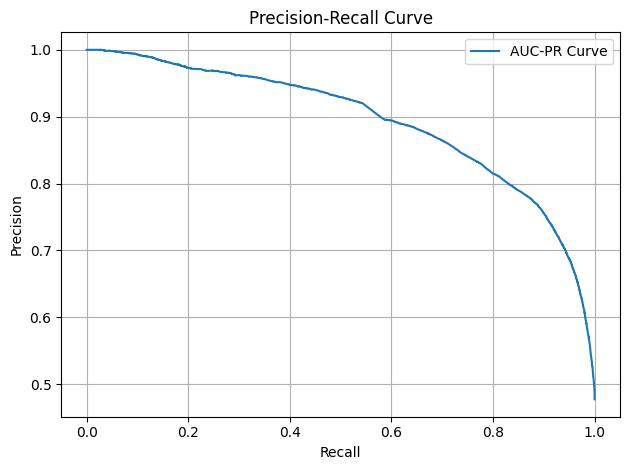

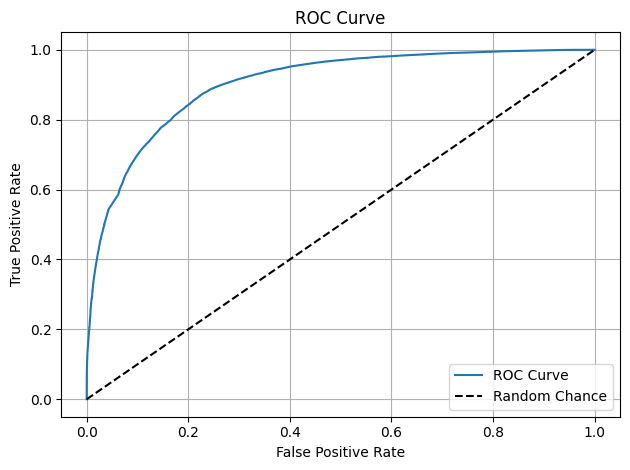

In [ ]:
load_and_evaluate_model()

/home/azureuser/cloudfiles/code/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:45:26] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


Top 10 SHAP Feature Importance:
shape: (10, 2)
┌─────────────────────────────────┬───────────────┐
│ feature                         ┆ mean_abs_shap │
│ ---                             ┆ ---           │
│ str                             ┆ f64           │
╞═════════════════════════════════╪═══════════════╡
│ service_type_supertype_other_c… ┆ 0.388022      │
│ billing_service_type_domestic_… ┆ 0.373072      │
│ service_type_supertype_other    ┆ 0.274773      │
│ billing_service_type_fees       ┆ 0.202089      │
│ billing_service_type_social_su… ┆ 0.18275       │
│ billing_service_type_case_mana… ┆ 0.179725      │
│ amount_4_week_sum               ┆ 0.128729      │
│ billing_service_type_social_su… ┆ 0.118331      │
│ billing_service_type_null       ┆ 0.101842      │
│ payable_duration_sum            ┆ 0.093545      │
└─────────────────────────────────┴───────────────┘


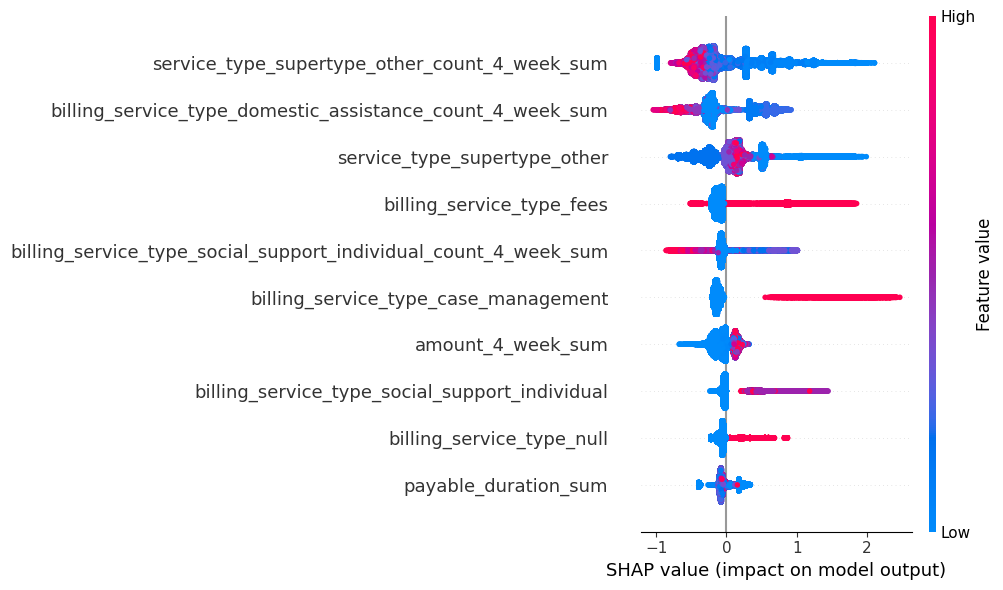

<Figure size 640x480 with 0 Axes>

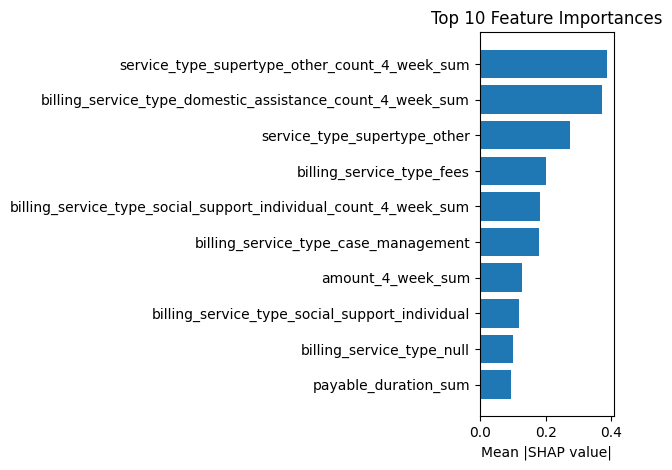

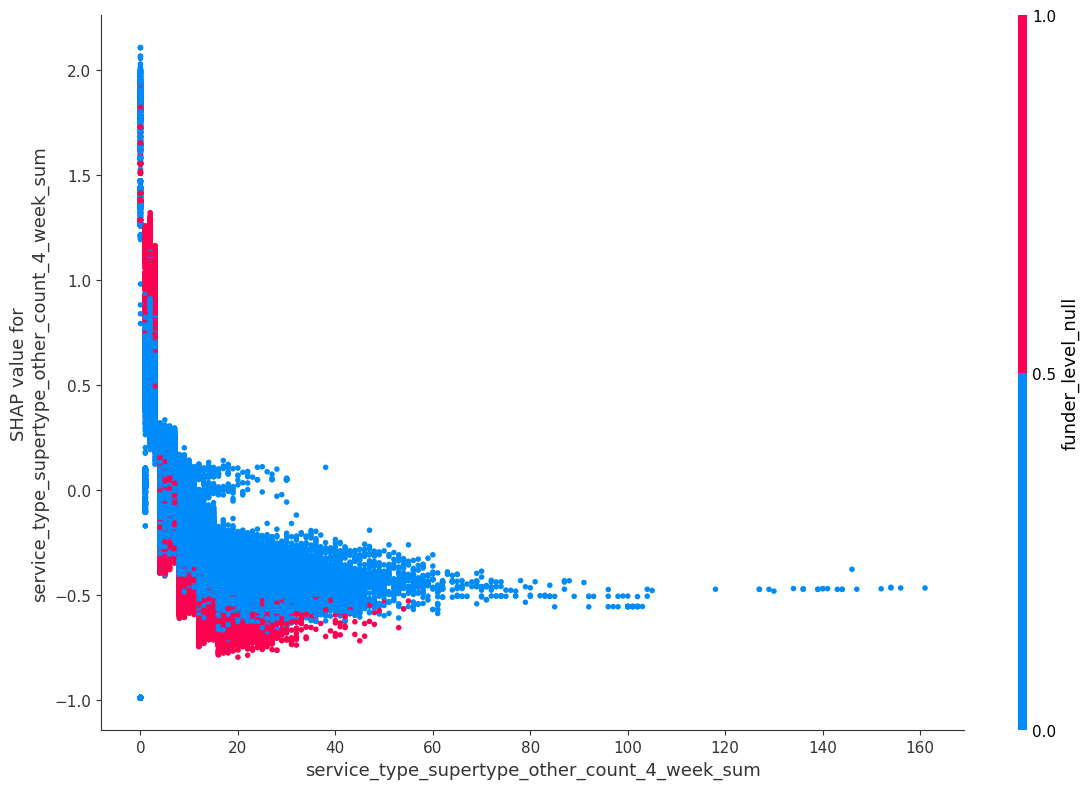

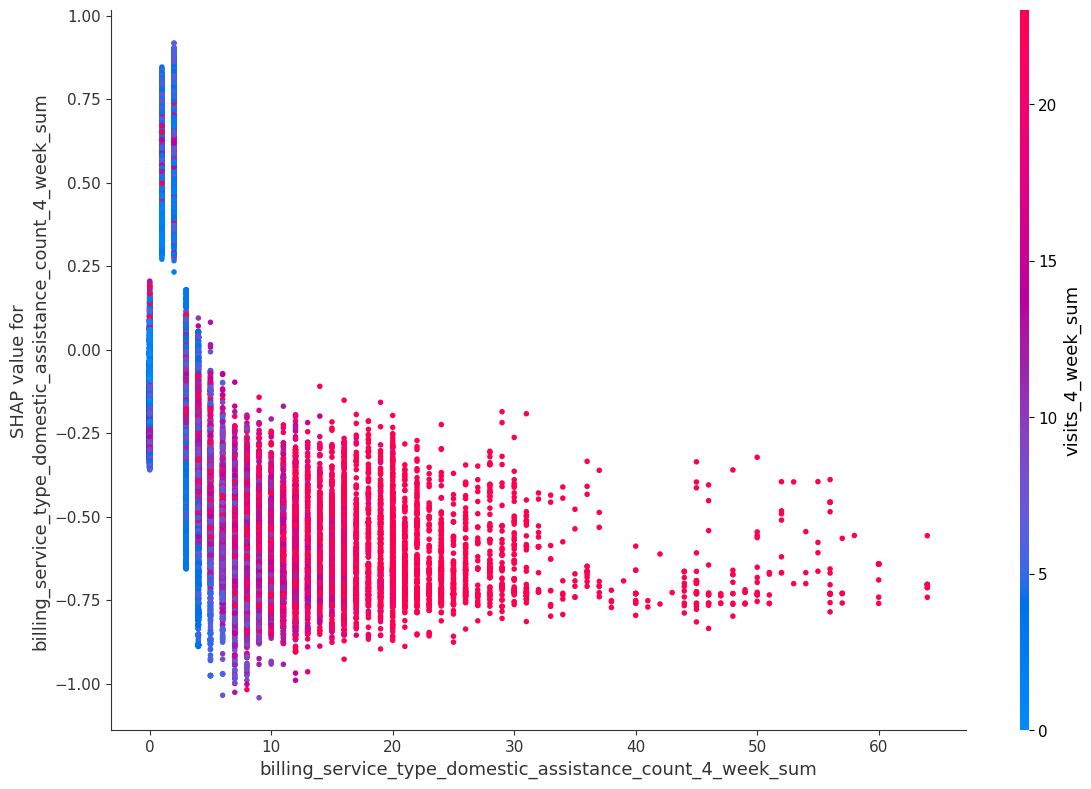

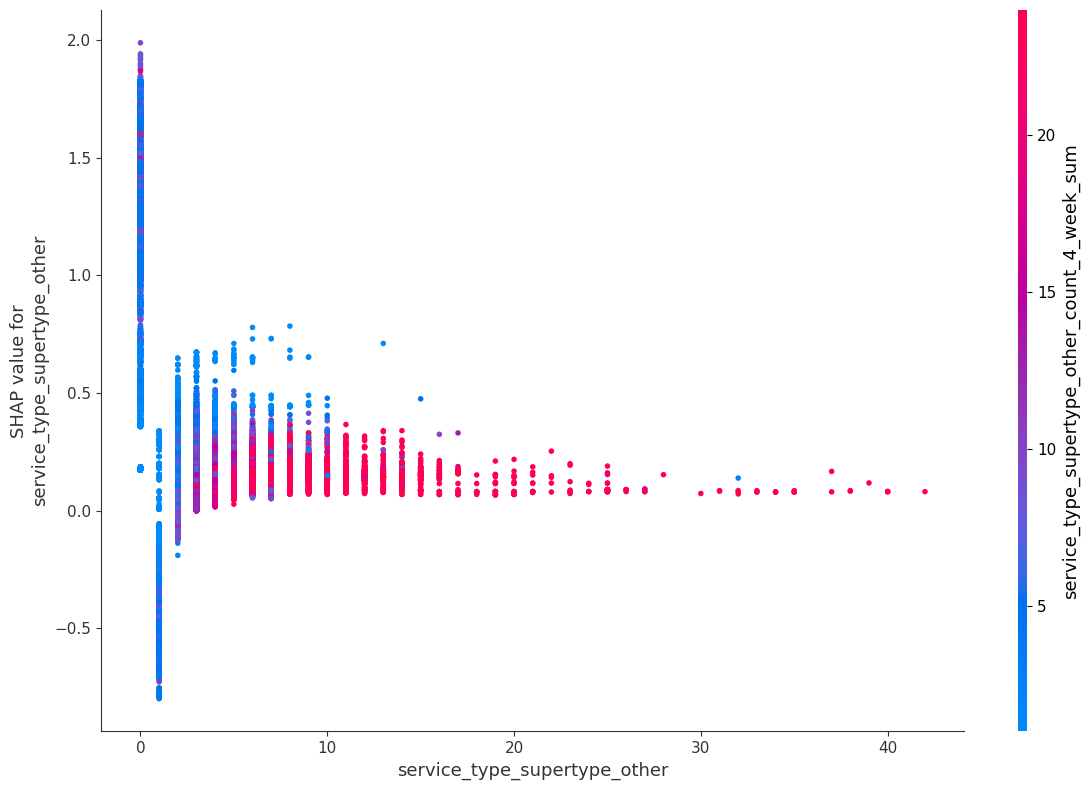

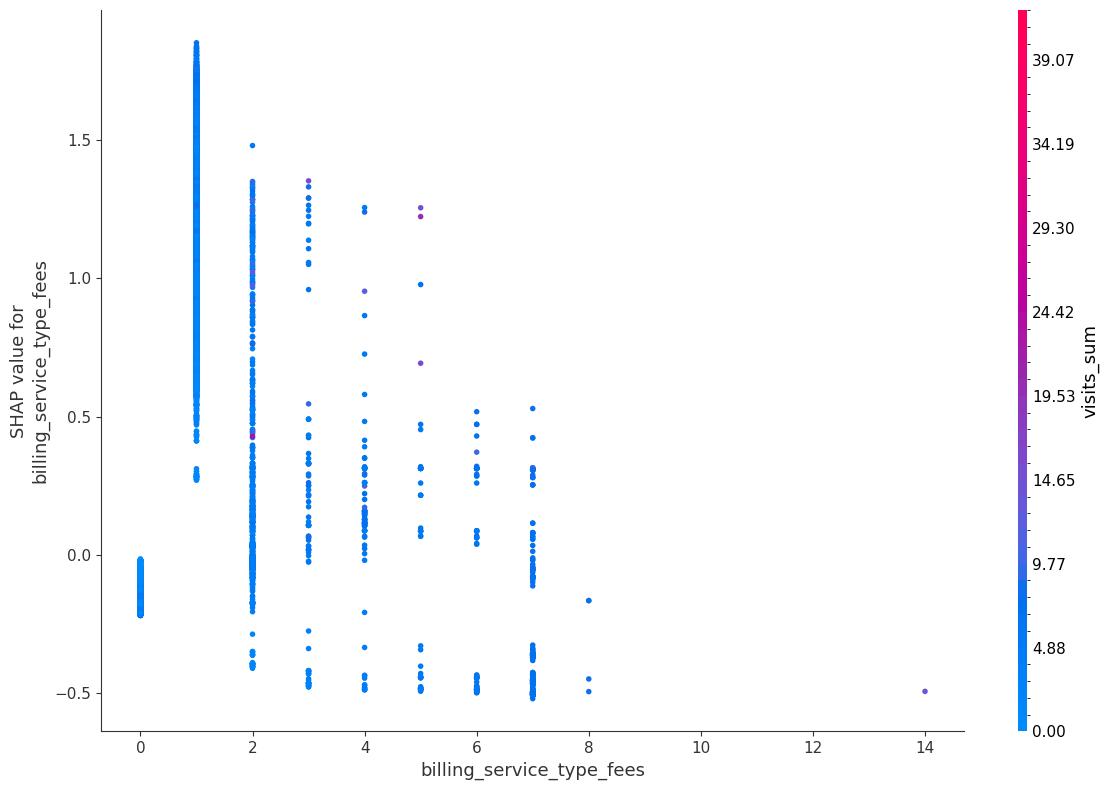

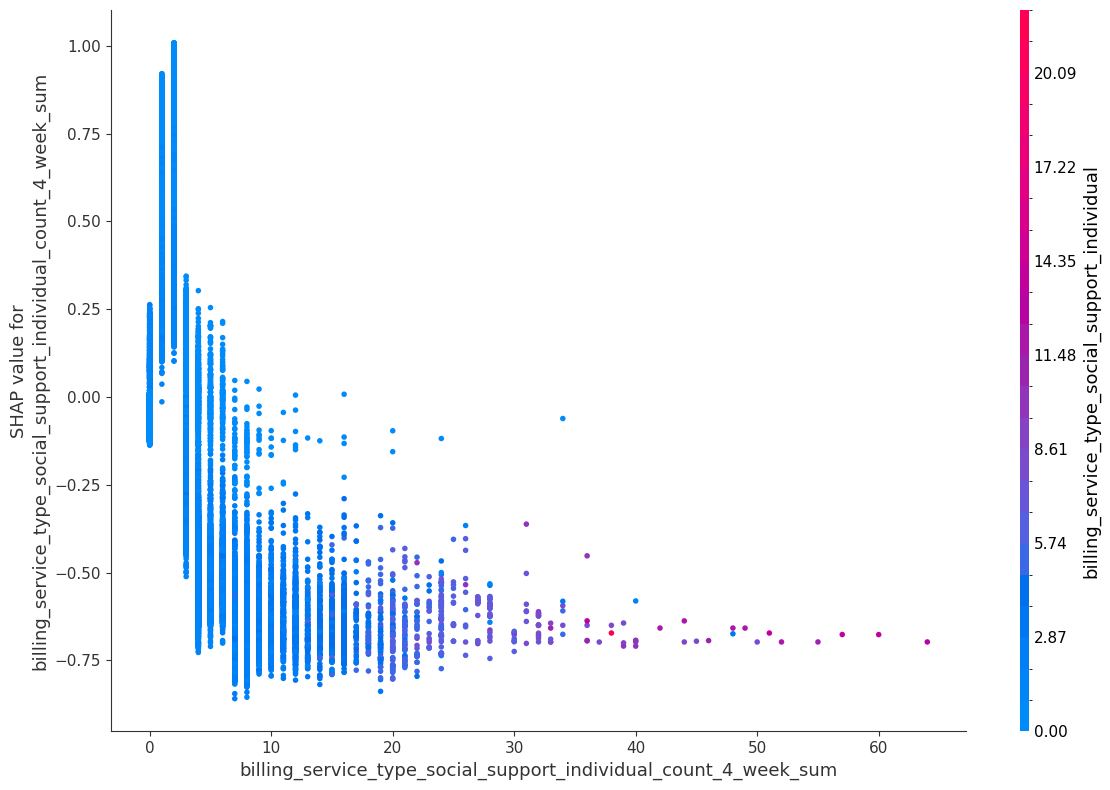

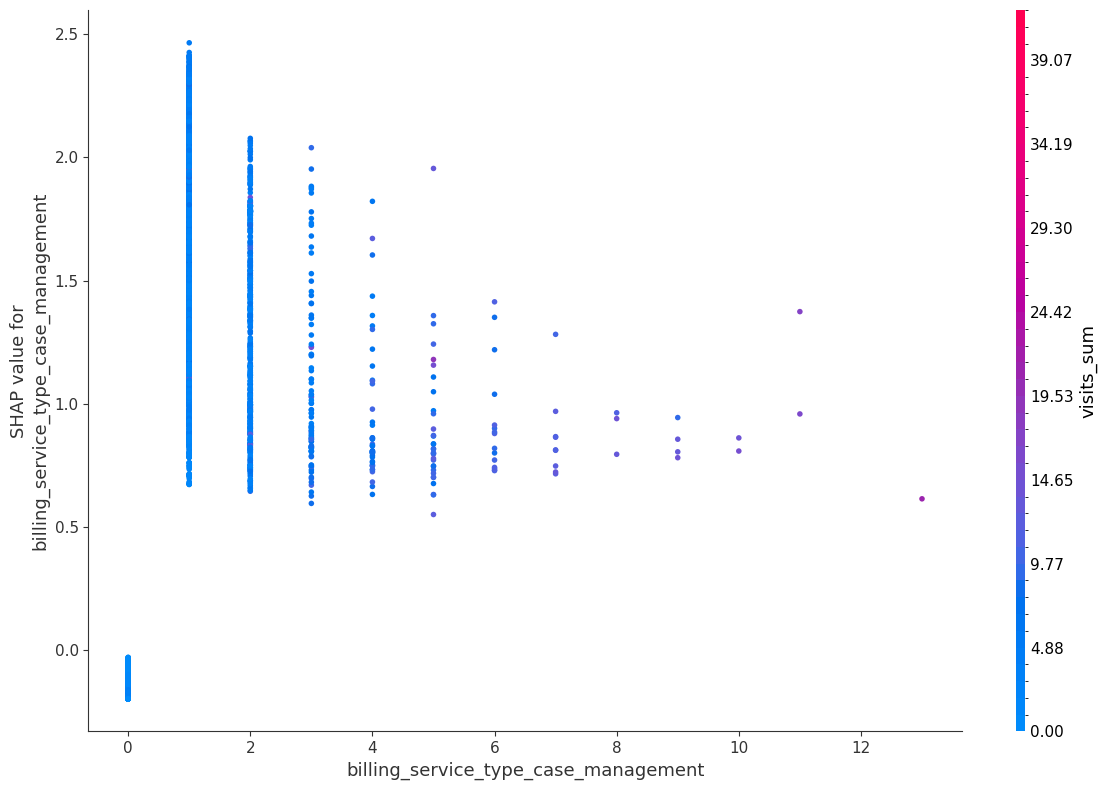

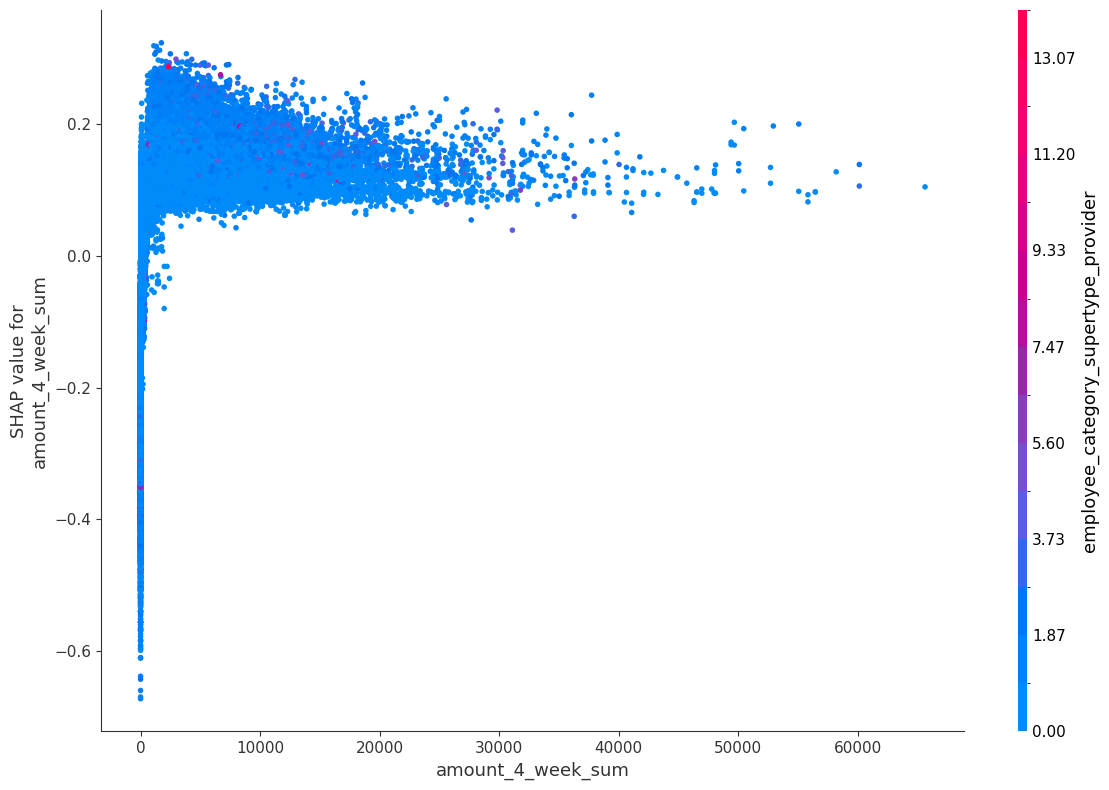

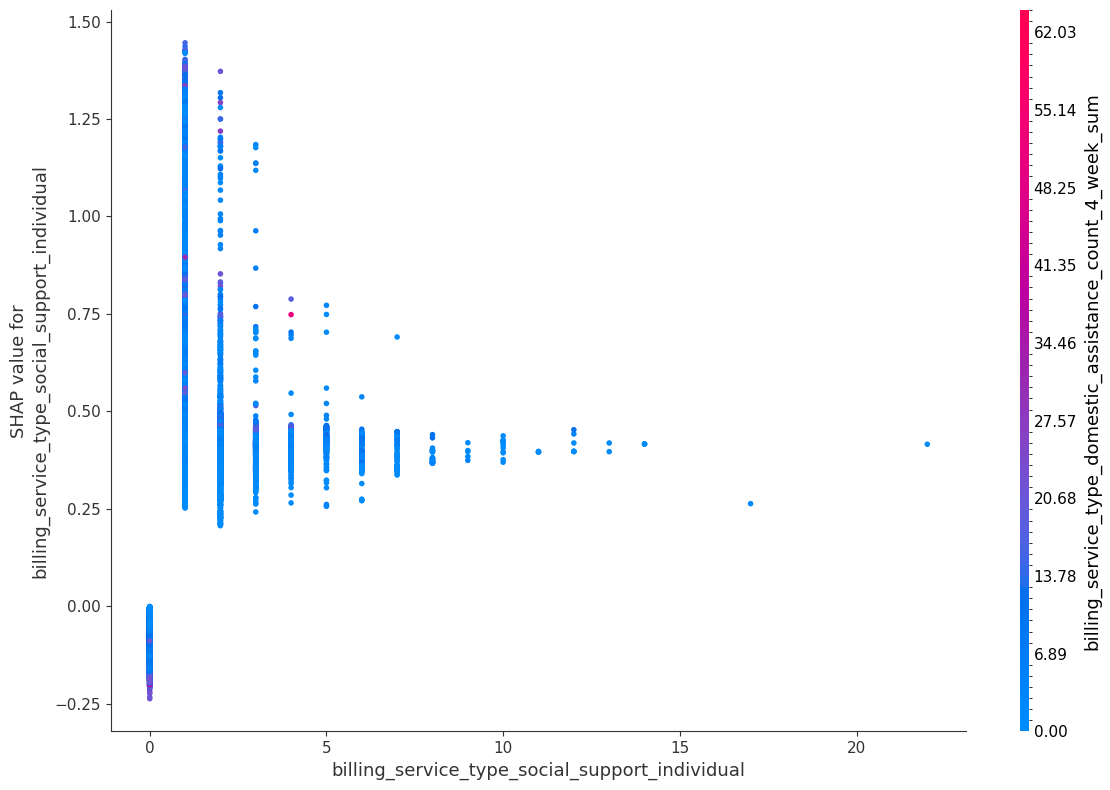

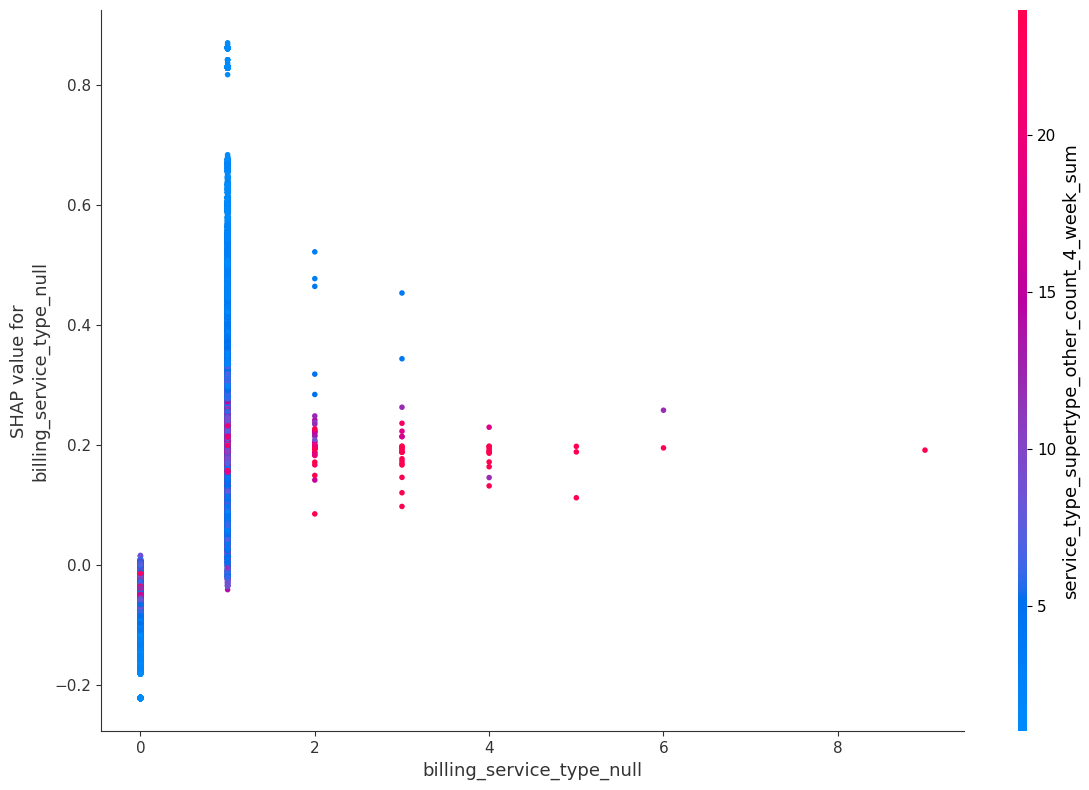

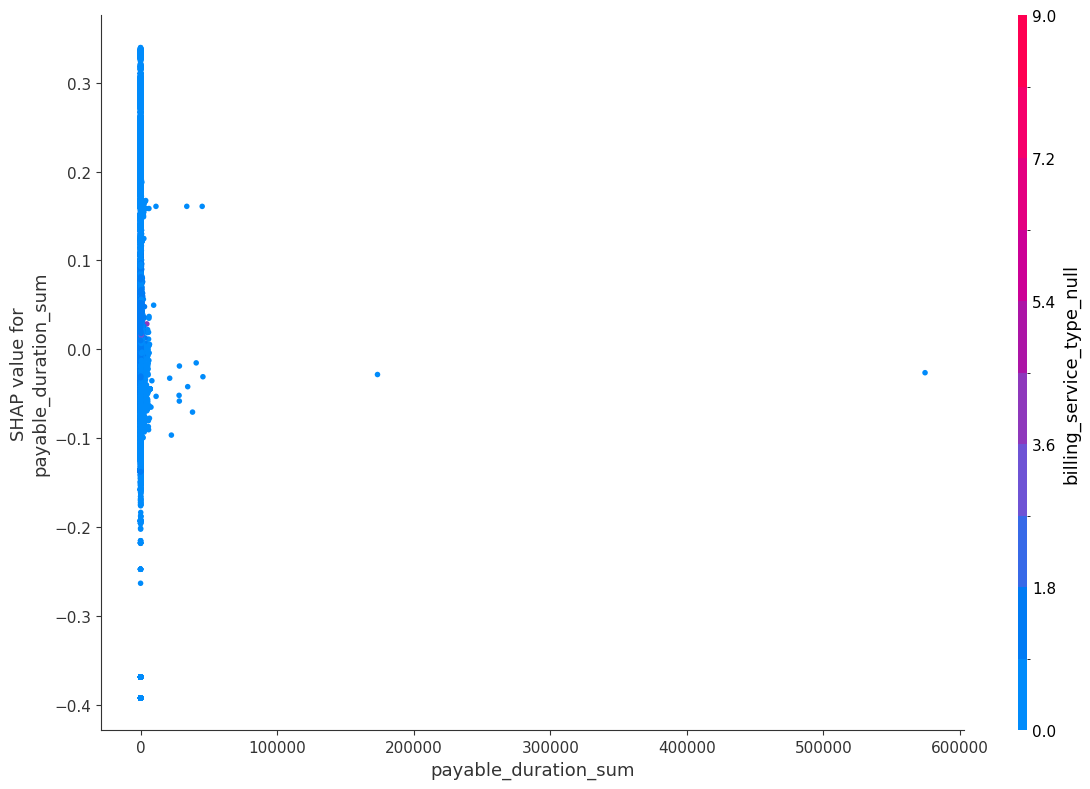

Local SHAP Waterfall Plot for First Test Instance:


100%|===================| 166053/166062 [19:58<00:00]        

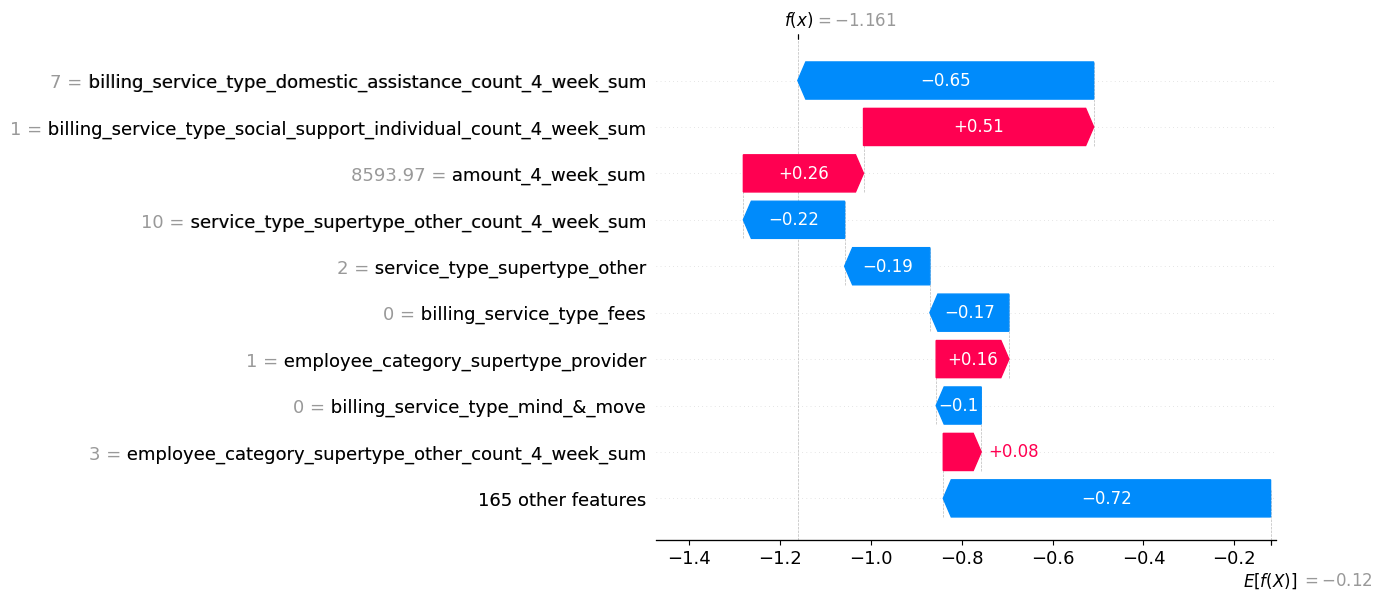

In [ ]:
shap_analysis()

## Simplified SHAP plot

In [ ]:
import pickle
from pathlib import Path
from beartype import beartype
import icontract
import numpy as np
import shap
import matplotlib.pyplot as plt
from rich import print as rprint
from rich.table import Table

@beartype
def shap_analysis() -> None:
    """
    Compute SHAP values for the trained XGBoost classifier,
    aggregate one-hot encoded categorical contributions back into
    their parent features—and for any categorical rolling features
    ending in '_count_4_week_sum', group their dummies into a single feature
    named '<category>_count_4_week_sum'. Then plot summary and bar charts.
    Rename specified categorical groups as configured in `rename_map`.
    """
    # 1. Load test split
    _, test_df = load_splits()

    # 2. Prepare features
    X_test, _, feature_cols = prepare_classification(test_df)

    # 3. Load model
    with open(MODEL_PATH, "rb") as f:
        clf, _ = pickle.load(f)

    # 4. Compute SHAP values
    explainer = shap.TreeExplainer(clf)
    raw_shap = explainer.shap_values(X_test)
    shap_vals = raw_shap[1] if isinstance(raw_shap, list) else raw_shap

    # 5. Per-feature mean(|SHAP|)
    abs_mean = np.abs(shap_vals).mean(axis=0)

    # 6. Define original categorical columns and rename map
    categorical_columns = [
        "employee_category_supertype",
        "funder_level",
        "billing_service_type",
        "direct_indirect",
        "status_reason_category",
        "service_type_supertype"
    ]
    # Map original groups to desired display names
    rename_map: dict[str, str] = {
        # Example: rename_map['employee_category_supertype'] = 'Employee Category'
        # Add your desired renamings below:
        'employee_category_supertype': 'employee_category',
        'service_type_supertype': 'service_type',
        'service_type_supertype_count_4_week_sum': 'service_type_count_4_week_sum',
        'employee_category_supertype_count_4_week_sum': 'employee_category_count_4_week_sum',
    }

    # 7. Map features to their aggregation group, applying renames
    idx_to_group: dict[str, list[int]] = {}
    matched = set()
    for idx, name in enumerate(feature_cols):
        for cat in categorical_columns:
            if name.startswith(f"{cat}_"):
                # rolling 3m dummy?
                if name.endswith("_count_4_week_sum"):
                    raw_group = f"{cat}_count_4_week_sum"
                else:
                    raw_group = cat
                # apply rename if present
                group = rename_map.get(raw_group, raw_group)
                idx_to_group.setdefault(group, []).append(idx)
                matched.add(idx)
                break

    # 8. Aggregate importances
    agg_imp: dict[str, float] = {}
    # 8a. Categorical groups
    for group_name, indices in idx_to_group.items():
        agg_imp[group_name] = float(abs_mean[indices].sum())
    # 8b. All other (numeric, rolling numeric) features stay solo
    for idx, name in enumerate(feature_cols):
        if idx not in matched:
            agg_imp[name] = float(abs_mean[idx])

    # 9. Sort and take top 10
    top10 = sorted(agg_imp.items(), key=lambda x: x[1], reverse=True)[:10]

    # 10. Display with rich
    table = Table(title="Top 10 SHAP Importances (grouped and renamed)")
    table.add_column("Feature", no_wrap=True)
    table.add_column("Mean |SHAP|", justify="right")
    for feature, importance in top10:
        table.add_row(feature, f"{importance:.6f}")
    _ = rprint(table)

    # 11. Bar chart of aggregated importances
    features, values = zip(*reversed(top10))
    plt.figure()
    plt.barh(features, values)
    plt.xlabel("Mean |SHAP value|")
    plt.title("Top 10 Aggregated Feature Importances")
    plt.tight_layout()
    _ = plt.show()

    # 12. SHAP summary plot on original features (top 10)
    shap.summary_plot(
        shap_vals,
        X_test,
        feature_names=feature_cols,
        max_display=10
    )
    plt.tight_layout()
    _ = plt.show()

    # 13. Dependence plots for any top10 feature that's in X_test
    for feat, _ in top10:
        # If we renamed a categorical group, it won't be in feature_cols
        if feat in feature_cols:
            shap.dependence_plot(
                feat,
                shap_vals,
                X_test,
                feature_names=feature_cols
            )
            plt.tight_layout()
            _ = plt.show()
        else:
            rprint(f"[yellow]Skipping dependence plot for aggregated feature '{feat}'[/yellow]")

     Top 10 SHAP Importances (grouped and renamed)     
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Feature                               ┃ Mean |SHAP| ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ billing_service_type                  │    1.048081 │
│ billing_service_type_count_4_week_sum │    0.790767 │
│ service_type_count_4_week_sum         │    0.388022 │
│ service_type                          │    0.274773 │
│ funder_level_count_4_week_sum         │    0.167612 │
│ funder_level                          │    0.131653 │
│ amount_4_week_sum                     │    0.128729 │
│ employee_category_count_4_week_sum    │    0.120913 │
│ payable_duration_sum                  │    0.093545 │
│ duration_4_week_sum                   │    0.083347 │
└───────────────────────────────────────┴─────────────┘

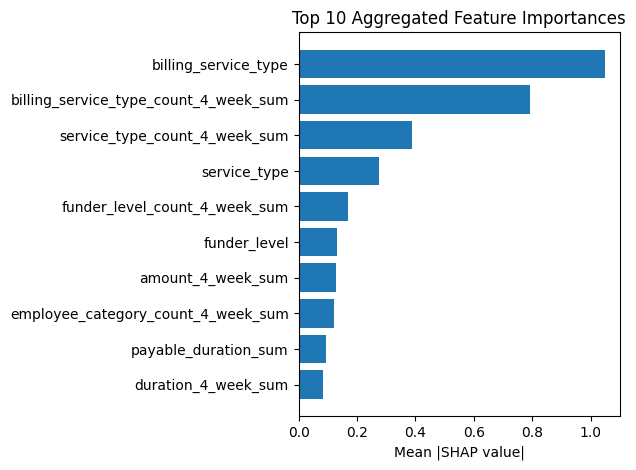

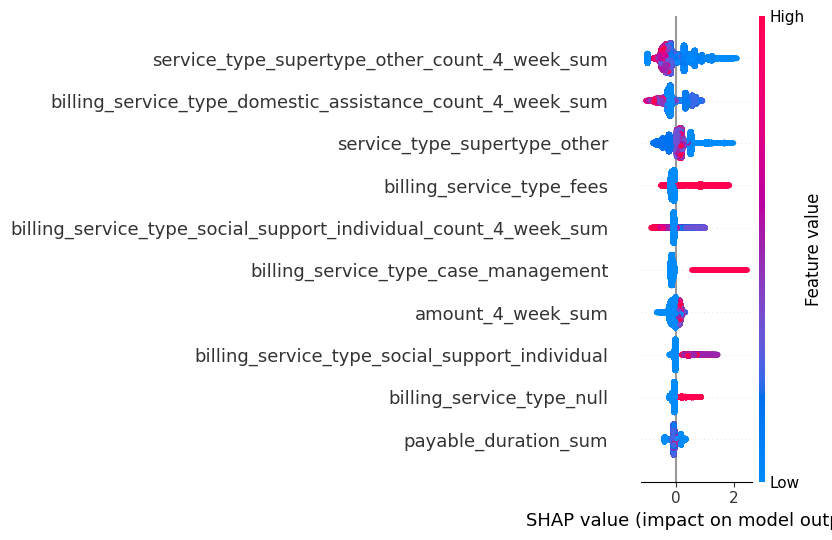

<Figure size 640x480 with 0 Axes>

Skipping dependence plot for aggregated feature 'billing_service_type'

Skipping dependence plot for aggregated feature 'billing_service_type_count_4_week_sum'

Skipping dependence plot for aggregated feature 'service_type_count_4_week_sum'

Skipping dependence plot for aggregated feature 'service_type'

Skipping dependence plot for aggregated feature 'funder_level_count_4_week_sum'

Skipping dependence plot for aggregated feature 'funder_level'

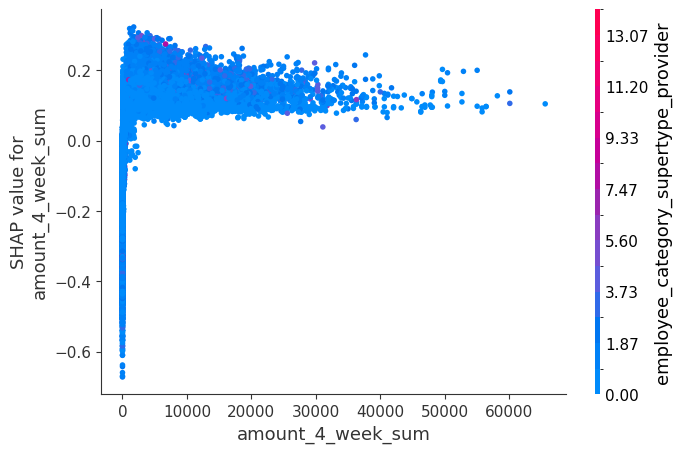

<Figure size 640x480 with 0 Axes>

Skipping dependence plot for aggregated feature 'employee_category_count_4_week_sum'

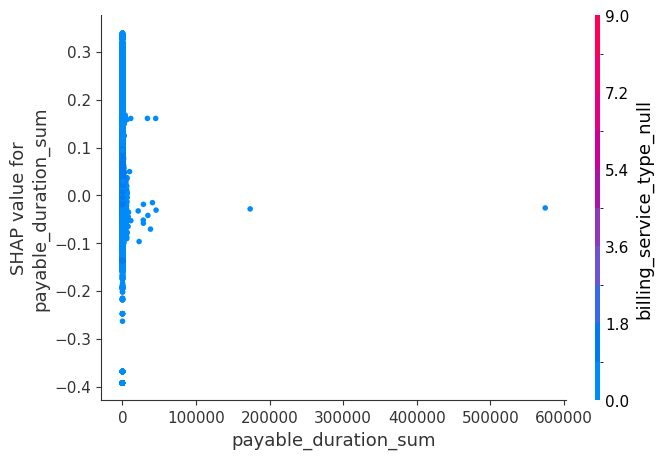

<Figure size 640x480 with 0 Axes>

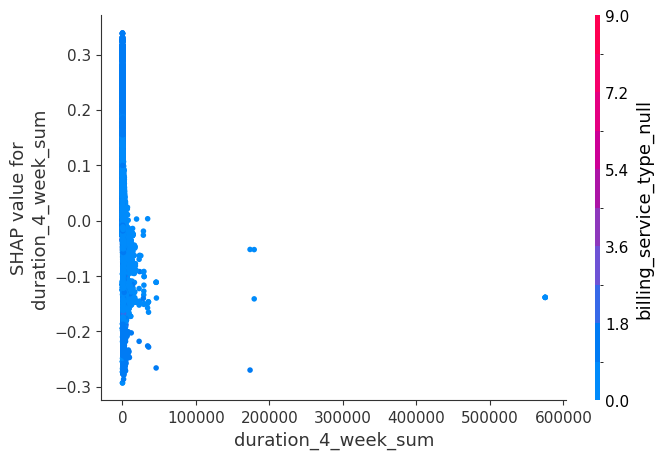

<Figure size 640x480 with 0 Axes>

In [ ]:
shap_analysis()

## Fairness

In [ ]:
# NOTE currently there are no sensitive features present within the data, so this code just runs over all the categorical columns
# Isn't a reliable indicator of fairness/doesn't depict anything really "insightful"

In [ ]:
from pathlib import Path
from typing import List
from beartype import beartype
import polars as pl
import pickle
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score
import pandas as pd

@beartype
def load_dataset(path: Path) -> pl.DataFrame:
    """
    Load a parquet dataset from a given path.
    """
    return pl.read_parquet(str(path))

@beartype
def extract_sensitive(
    df: pl.DataFrame, attributes: List[str]
) -> pd.DataFrame:
    """
    Extract sensitive attributes from one-hot dummy columns.
    """
    out = []
    for attr in attributes:
        # pick only true one-hot columns
        dummy = [c for c in df.columns if c.startswith(f"{attr}_") and not c.endswith("_count_4_week_sum")]
        if not dummy:
            raise ValueError(f"No dummy columns for '{attr}'")
        # compute argmax index
        idx_col = df.select(
            pl.concat_list([pl.col(c) for c in dummy]).list.arg_max().alias("_idx")
        )
        # map index to category
        categories = [c.split(f"{attr}_")[1] for c in dummy]
        map_df = pl.DataFrame({"_idx": list(range(len(categories))), attr: categories})
        series = idx_col.join(map_df, on="_idx")[attr].to_pandas()
        series.name = attr
        out.append(series)
    return pd.concat(out, axis=1)


# Paths
model_path = Path("output/xgb_bc_weekly.pkl")
test_path = Path("output/test_df_bc_weekly.parquet")

# Load
df = load_dataset(test_path)
protected = [
    "employee_category_supertype",
    "funder_level",
    "billing_service_type",
    "direct_indirect",
    "status_reason_category",
    "service_type_supertype"
]
sens = extract_sensitive(df, protected)
y_true = df["target"].to_numpy()
with open(model_path, "rb") as f:
    obj = pickle.load(f)
model = obj[0] if isinstance(obj, tuple) else obj

# Prepare features
drop = {"client_id_joint", "event_date", "target"}
features = [c for c in df.columns if c not in drop]
X = (
    df.select(features)
        .with_columns([pl.col(c).cast(pl.Float64).alias(c) for c in features])
        .to_numpy()
)

# Predict
y_pred = model.predict(X)

# Compute gaps per attribute
results = []
for attr in protected:
    mf = MetricFrame(
        metrics={"selection_rate": selection_rate, "accuracy": accuracy_score},
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sens[attr]
    )
    gap = mf.difference(method="between_groups")
    results.append({
        "Attribute": attr,
        "DP_gap": gap["selection_rate"],
        "Acc_gap": gap["accuracy"]
    })

table = pd.DataFrame(results)
print(table)

Attribute    DP_gap   Acc_gap
0  employee_category_supertype  0.730082  0.350318
1                 funder_level  0.993506  0.311111
2         billing_service_type  0.989305  0.560006
3              direct_indirect  0.212605  0.034475
4       status_reason_category  0.700000  0.500000
5       service_type_supertype  0.000000  0.000000

## Drift

In [ ]:
from pathlib import Path
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
from typing import List, Tuple, Final
import polars as pl
import numpy as np
import pickle
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from nannyml.drift.univariate.calculator import UnivariateDriftCalculator
from beartype import beartype

# Paths and constants matching training setup
DATA_PATH: Final[Path] = Path("output/weekly_bc_data_with_4w.parquet")
TRAIN_DF_PATH: Final[Path] = Path("output/train_df_bc_weekly.parquet")
TEST_DF_PATH: Final[Path] = Path("output/test_df_bc_weekly.parquet")
MODEL_PATH: Final[Path] = Path("output/xgb_bc_weekly.pkl")
SPLIT_DATE_STR: Final[str] = "2024-09-01"
SPLIT_DATE: Final[date] = datetime.strptime(SPLIT_DATE_STR, "%Y-%m-%d").date()

@beartype
def load_splits() -> Tuple[pl.DataFrame, pl.DataFrame]:
    train_df = pl.read_parquet(TRAIN_DF_PATH)
    test_df = pl.read_parquet(TEST_DF_PATH)
    return train_df, test_df

@beartype
def load_model(model_path: Path) -> Tuple[XGBClassifier, List[str]]:
    with open(model_path, "rb") as f:
        clf, feature_cols = pickle.load(f)
    return clf, feature_cols

@beartype
def get_time_windows(
    df: pl.DataFrame,
    date_col: str,
    window_size_months: int,
    start_date: date = None,
) -> List[Tuple[date, date]]:
    """
    Generate sequential windows of fixed month size starting at start_date (split date)
    until the max date in df. The final window ends exactly at the latest data point.

    Parameters
    ----------
    df : pl.DataFrame
        DataFrame containing a datetime column.
    date_col : str
        Name of the datetime column.
    window_size_months : int
        Length of each window in months.
    start_date : date, optional
        Start of the first window; defaults to earliest date in df.

    Returns
    -------
    List[Tuple[date, date]]
        List of (start, end) dates for each window.
    """
    windows: List[Tuple[date, date]] = []
    # Determine first and last timestamps
    first = start_date or df.select(pl.col(date_col).min()).item()
    max_ts = df.select(pl.col(date_col).max()).item()
    current_start = first

    # Slide windows forward until we cover up to max_ts
    while current_start < max_ts:
        candidate_end = current_start + relativedelta(months=window_size_months)
        # Cap the final window to the actual max timestamp
        window_end = candidate_end if candidate_end <= max_ts else max_ts
        windows.append((current_start, window_end))
        current_start = candidate_end

    return windows

@beartype
def main(
    date_col: str = "event_date",
    target_col: str = "target",
    window_size_months: int = 2,
) -> None:
    # Load data and model
    train_df, test_df = load_splits()
    clf, feature_cols = load_model(MODEL_PATH)

    # Fit drift calculator
    ref_pd = train_df.select(feature_cols).to_pandas()
    drift_calc = UnivariateDriftCalculator(column_names=feature_cols)
    drift_calc.fit(ref_pd)

    # Prepare results container
    results = []

    # Generate and iterate windows
    windows = get_time_windows(test_df, date_col, window_size_months, start_date=SPLIT_DATE)
    for start, end in windows:
        df_win = test_df.filter(
            (pl.col(date_col) >= start) & (pl.col(date_col) < end)
        )
        if df_win.is_empty():
            continue

        # Compute drift
        prod_pd = df_win.select(feature_cols).to_pandas()
        drift_res = drift_calc.calculate(prod_pd)
        df_drift = drift_res.to_df()
        value_cols = [c for c in df_drift.columns if c[-1] == 'value']
        psi_vals = df_drift[value_cols[0]]
        psi_agg = float(psi_vals.mean())

        # Compute performance
        y_true = df_win.select(target_col).to_series().to_numpy()
        X_win = df_win.select(feature_cols).to_numpy()
        y_proba = clf.predict_proba(X_win)[:, 1]
        auc_val = float(roc_auc_score(y_true, y_proba)) if np.unique(y_true).size > 1 else float('nan')

        results.append({
            "start": start,
            "end": end,
            "psi": psi_agg,
            "auc": auc_val,
        })

    # Create and print summary DataFrame
    summary_df = pl.DataFrame(results)
    print(summary_df)

if __name__ == "__main__":
    main()


shape: (4, 4)
┌────────────┬────────────┬──────────┬──────────┐
│ start      ┆ end        ┆ psi      ┆ auc      │
│ ---        ┆ ---        ┆ ---      ┆ ---      │
│ date       ┆ date       ┆ f64      ┆ f64      │
╞════════════╪════════════╪══════════╪══════════╡
│ 2024-09-01 ┆ 2024-11-01 ┆ 0.125031 ┆ 0.898487 │
│ 2024-11-01 ┆ 2025-01-01 ┆ 0.120655 ┆ 0.883721 │
│ 2025-01-01 ┆ 2025-03-01 ┆ 0.132464 ┆ 0.919333 │
│ 2025-03-01 ┆ 2025-03-31 ┆ 0.202056 ┆ 0.930641 │
└────────────┴────────────┴──────────┴──────────┘

In [ ]:
# NOTE most recent window (2025-03-01 ┆ 2025-03-31) is only for a month as that is the last datapoint.
# However, based on this data and the triggers PSI>0.2 OR AUC_drop>2 %, the model should be retrained in march/april.

In [ ]:
from pathlib import Path
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
from typing import List, Tuple, Final
import polars as pl
import numpy as np
import pickle
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from nannyml.drift.univariate.calculator import UnivariateDriftCalculator
from beartype import beartype

# Paths and constants matching training setup
DATA_PATH: Final[Path] = Path("output/weekly_bc_data_with_4w.parquet")
TRAIN_DF_PATH: Final[Path] = Path("output/train_df_bc_weekly.parquet")
TEST_DF_PATH: Final[Path] = Path("output/test_df_bc_weekly.parquet")
MODEL_PATH: Final[Path] = Path("output/xgb_bc_weekly.pkl")
SPLIT_DATE_STR: Final[str] = "2024-09-01"
SPLIT_DATE: Final[date] = datetime.strptime(SPLIT_DATE_STR, "%Y-%m-%d").date()

@beartype
def load_splits() -> Tuple[pl.DataFrame, pl.DataFrame]:
    train_df = pl.read_parquet(TRAIN_DF_PATH)
    test_df = pl.read_parquet(TEST_DF_PATH)
    return train_df, test_df

@beartype
def load_model(model_path: Path) -> Tuple[XGBClassifier, List[str]]:
    with open(model_path, "rb") as f:
        clf, feature_cols = pickle.load(f)
    return clf, feature_cols

@beartype
def get_time_windows(
    df: pl.DataFrame,
    date_col: str,
    window_size_months: int,
    start_date: date = None,
) -> List[Tuple[date, date]]:
    """
    Generate sequential windows of fixed month size starting at start_date (split date)
    until the max date in df. The final window ends exactly at the latest data point.

    Parameters
    ----------
    df : pl.DataFrame
        DataFrame containing a datetime column.
    date_col : str
        Name of the datetime column.
    window_size_months : int
        Length of each window in months.
    start_date : date, optional
        Start of the first window; defaults to earliest date in df.

    Returns
    -------
    List[Tuple[date, date]]
        List of (start, end) dates for each window.
    """
    windows: List[Tuple[date, date]] = []
    # Determine first and last timestamps
    first = start_date or df.select(pl.col(date_col).min()).item()
    max_ts = df.select(pl.col(date_col).max()).item()
    current_start = first

    # Slide windows forward until we cover up to max_ts
    while current_start < max_ts:
        candidate_end = current_start + relativedelta(months=window_size_months)
        # Cap the final window to the actual max timestamp
        window_end = candidate_end if candidate_end <= max_ts else max_ts
        windows.append((current_start, window_end))
        current_start = candidate_end

    return windows

@beartype
def main(
    date_col: str = "event_date",
    target_col: str = "target",
    window_size_months: int = 2,
) -> None:
    # Load data and model
    train_df, test_df = load_splits()
    clf, feature_cols = load_model(MODEL_PATH)

    # Fit drift calculator
    ref_pd = train_df.select(feature_cols).to_pandas()
    drift_calc = UnivariateDriftCalculator(column_names=feature_cols)
    drift_calc.fit(ref_pd)

    # Prepare results container
    results = []

    # Generate and iterate windows
    windows = get_time_windows(test_df, date_col, window_size_months, start_date=SPLIT_DATE)
    for start, end in windows:
        df_win = test_df.filter(
            (pl.col(date_col) >= start) & (pl.col(date_col) < end)
        )
        if df_win.is_empty():
            continue

        # Compute drift
        prod_pd = df_win.select(feature_cols).to_pandas()
        drift_res = drift_calc.calculate(prod_pd)
        df_drift = drift_res.to_df()
        value_cols = [c for c in df_drift.columns if c[-1] == 'value']
        psi_vals = df_drift[value_cols[0]]
        psi_agg = float(psi_vals.mean())

        # Compute performance
        y_true = df_win.select(target_col).to_series().to_numpy()
        X_win = df_win.select(feature_cols).to_numpy()
        y_pred = clf.predict(X_win)
        acc_val = float(accuracy_score(y_true, y_pred)) if np.unique(y_true).size > 1 else float('nan')

        results.append({
            "start": start,
            "end": end,
            "psi": psi_agg,
            "accuracy": acc_val,
        })

    # Create and print summary DataFrame
    summary_df = pl.DataFrame(results)
    print(summary_df)

if __name__ == "__main__":
    main()

/home/azureuser/cloudfiles/code/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:41:23] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


shape: (4, 4)
┌────────────┬────────────┬──────────┬──────────┐
│ start      ┆ end        ┆ psi      ┆ accuracy │
│ ---        ┆ ---        ┆ ---      ┆ ---      │
│ date       ┆ date       ┆ f64      ┆ f64      │
╞════════════╪════════════╪══════════╪══════════╡
│ 2024-09-01 ┆ 2024-11-01 ┆ 0.125031 ┆ 0.814015 │
│ 2024-11-01 ┆ 2025-01-01 ┆ 0.120655 ┆ 0.796097 │
│ 2025-01-01 ┆ 2025-03-01 ┆ 0.132464 ┆ 0.833924 │
│ 2025-03-01 ┆ 2025-03-31 ┆ 0.202056 ┆ 0.843248 │
└────────────┴────────────┴──────────┴──────────┘


# Time Horizons

## Time Horizons - AutoML

In [ ]:
from pathlib import Path
from typing import Final, Tuple, List, Dict
import polars as pl
import numpy as np
import pickle
import json
import matplotlib.pyplot as plt
from beartype import beartype
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, average_precision_score, precision_recall_curve, roc_curve, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from mapie.classification import SplitConformalClassifier
import shap
from flaml import AutoML
from datetime import datetime, date
import xgboost as xgb

horizons = [0, 1, 2, 3, 4]

# Paths
OUTPUT_DIR: Final[Path] = Path("output")
DATA_PATH: Final[Path]   = OUTPUT_DIR / "weekly_bc_data_with_4w.parquet"
SHIFTED_DIR: Final[Path] = OUTPUT_DIR / "shifted_bc_weekly"
MODEL_DIR: Final[Path]   = OUTPUT_DIR / "models_bc_weekly"
SHIFTED_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Split date for train/test
SPLIT_DATE_STR: Final[str] = "2024-09-01"
SPLIT_DATE: Final[date]    = datetime.strptime(SPLIT_DATE_STR, "%Y-%m-%d").date()

@beartype
def save_shifted_datasets(horizons: List[int]) -> None:
    df = pl.read_parquet(DATA_PATH)
    df = _ensure_date(df)
    for h in horizons:
        shifted = (
            df.sort(["client_id_joint", "event_date"])
              .with_columns(
                  pl.col("target").shift(-h).over("client_id_joint").alias(f"target_t+{h}")
              )
              .filter(pl.col(f"target_t+{h}").is_not_null())
              .drop("target")
        )
        out_path = SHIFTED_DIR / f"h{h}.parquet"
        shifted.write_parquet(out_path)
        print(f"Saved shifted dataset for horizon +{h} weeks to: {out_path}")

@beartype
def prepare_classification(
    df: pl.DataFrame,
    target_col: str
) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Build feature matrix X and label vector y, dynamically recasting non-numeric columns or dropping them with warnings.

    Excludes: client_id_joint, event_date, and the shifted target.
    Attempts to cast any other columns to Float64; if casting fails, drops that column and prints a warning.
    """
    exclude_cols = {"client_id_joint", "event_date", target_col}
    feature_cols: List[str] = []
    cast_df = df
    dropped: List[str] = []

    for c in df.columns:
        if c in exclude_cols:
            continue
        dtype = df[c].dtype
        if dtype in (pl.Float64, pl.Int64):
            feature_cols.append(c)
        else:
            # try to cast to Float64
            try:
                cast_series = df[c].cast(pl.Float64)
                # check if cast introduced nulls where there were values
                orig_non_null = df[c].drop_nulls().len()
                cast_non_null = cast_series.drop_nulls().len()
                if cast_non_null < orig_non_null:
                    raise ValueError(f"Casting {c} introduced nulls")
                cast_df = cast_df.with_columns([cast_series.alias(c)])
                feature_cols.append(c)
            except Exception as e:
                dropped.append(c)
                print(f"Warning: dropping column '{c}' (could not cast to numeric): {e}")

    # Select final features
    X = cast_df.select(feature_cols).to_numpy()
    y = cast_df.select(target_col).to_series().to_numpy().astype(int)
    if dropped:
        print(f"Dropped columns due to non-numeric types or cast failures: {dropped}")
    return X, y, feature_cols

@beartype
def train_horizon_models(
    horizons: List[int], time_budget: int = 30
) -> Dict[int, Tuple[XGBClassifier, List[str]]]:
    models: Dict[int, Tuple[XGBClassifier, List[str]]] = {}
    for h in horizons:
        df_h = pl.read_parquet(SHIFTED_DIR / f"h{h}.parquet")
        df_h = _ensure_date(df_h)
        train_df = df_h.filter(pl.col("event_date") < SPLIT_DATE)
        X_train, y_train, feature_cols = prepare_classification(train_df, f"target_t+{h}")

        automl = AutoML()
        automl_settings = {
            "time_budget": time_budget,
            "task": "classification",
            "estimator_list": ["xgboost"],
            "n_jobs": -1
        }
        automl.fit(X_train=X_train, y_train=y_train, **automl_settings)
        if automl.model is None:
            raise RuntimeError(f"FLAML did not produce a model for horizon +{h}.")
        clf = automl.model.estimator if hasattr(automl.model, "estimator") else automl.model

        with open(MODEL_DIR / f"xgb_bc_h{h}.pkl", "wb") as f_model:
            pickle.dump(clf, f_model)

        models[h] = (clf, feature_cols)
        print(f"Trained & saved horizon +{h} model")
    return models

@beartype
def evaluate_horizon_models_with_mapie(
    horizons: list[int],  # e.g., [0, 1, 2]
    alpha: float = 0.1,
    calibration_size: float = 0.2
) -> None:
    for h in horizons:
        # === Load model ===
        model_path = MODEL_DIR / f"xgb_bc_h{h}.pkl"
        if not model_path.exists():
            print(f"Model file not found for horizon {h}: {model_path}")
            continue

        with open(model_path, "rb") as f:
            clf = pickle.load(f)

        # Load data
        df_h = pl.read_parquet(SHIFTED_DIR / f"h{h}.parquet")
        df_h = _ensure_date(df_h)

        # Data split
        train_df = df_h.filter(pl.col("event_date") < SPLIT_DATE)
        test_df  = df_h.filter(pl.col("event_date") >= SPLIT_DATE)

        train_df_sorted = train_df.sort("event_date")
        n_total = train_df_sorted.height
        n_cal = int(calibration_size * n_total)
        cal_df = train_df_sorted.tail(n_cal)
        hold_df = train_df_sorted.head(n_total - n_cal)

        X_cal, y_cal, _ = prepare_classification(cal_df, f"target_t+{h}")
        X_hold, y_hold, _ = prepare_classification(hold_df, f"target_t+{h}")

        # === Fit conformal predictor ===
        cl = 1 - alpha
        conformal = SplitConformalClassifier(
            estimator=clf,
            confidence_level=cl,
            random_state=42,
            n_jobs=-1
        )
        conformal.conformalize(X_cal, y_cal)

        # Save conformal version for future
        cal_path = MODEL_DIR / f"xgb_bc_h{h}_conformal.pkl"
        with open(cal_path, "wb") as f_cal:
            pickle.dump(conformal, f_cal)
        print(f"Saved conformal calibrator for horizon +{h} to: {cal_path}")

        y_hold_sets = conformal.predict(X_hold)
        if isinstance(y_hold_sets, np.ndarray) and y_hold_sets.ndim == 1:
            hold_coverage = np.mean(y_hold_sets == y_hold)
        else:
            hold_coverage = np.mean([y_hold[i] in y_hold_sets[i] for i in range(len(y_hold_sets))])
        print(f"Calibration coverage on held-out set for horizon +{h}: {hold_coverage:.3f}")

        X_test, y_test, _ = prepare_classification(test_df, f"target_t+{h}")
        y_test_sets = conformal.predict(X_test)
        y_proba = clf.predict_proba(X_test)[:, 1]

        if isinstance(y_test_sets, np.ndarray) and y_test_sets.ndim == 1:
            y_pred = y_test_sets.astype(int)
        else:
            y_pred = np.array([
                1 in s if isinstance(s, (set, list, tuple)) else bool(s)
                for s in y_test_sets
            ])

        print(f"=== Evaluation for horizon +{h} weeks ===")
        print(classification_report(y_test, y_pred))
        print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
        print(f"PR AUC: {average_precision_score(y_test, y_proba):.4f}")
        print(confusion_matrix(y_test, y_pred))

        # Brier score
        brier = brier_score_loss(y_test, y_proba)
        print(f"Brier Score (horizon +{h}): {brier:.4f}")

        # Expected Calibration Error (ECE)
        def expected_calibration_error(y_true, y_prob, n_bins=10):
            bins = np.linspace(0, 1, n_bins + 1)
            bin_ids = np.digitize(y_prob, bins) - 1
            ece = 0.0
            for i in range(n_bins):
                idx = bin_ids == i
                if np.any(idx):
                    prob_avg = np.mean(y_prob[idx])
                    acc_avg = np.mean(y_true[idx])
                    ece += np.abs(acc_avg - prob_avg) * len(y_prob[idx]) / len(y_prob)
            return ece

        ece = expected_calibration_error(y_test, y_proba)
        print(f"Expected Calibration Error (ECE) (horizon +{h}): {ece:.4f}")

        # PR curve
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        plt.figure()
        plt.plot(recall, precision, label="AUC-PR")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"PR Curve (horizon +{h})")
        plt.tight_layout()
        plt.show()

        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label="ROC")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title(f"ROC Curve (horizon +{h})")
        plt.tight_layout()
        plt.show()

        # === Calibration Evaluation ===
        # Calibration curve (Reliability diagram)
        prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)

        plt.figure()
        plt.plot(prob_true, prob_pred, marker='o', label='Model')  # swapped arguments
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
        plt.xlabel("Fraction of positives")  # now x-axis
        plt.ylabel("Mean predicted probability")  # now y-axis
        plt.title(f"Calibration Curve (horizon +{h})")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

@beartype
def recommend_week_from_probabilities(
    probas: Dict[int, np.ndarray],
    lowers: Dict[int, np.ndarray],
    threshold: float = 0.6,
    lower_bound: float = 0.5
) -> List[int]:
    recs: List[int] = []
    n = len(next(iter(probas.values())))
    for i in range(n):
        valid = [h for h in probas if probas[h][i] > threshold and lowers[h][i] > lower_bound]
        recs.append(max(valid) if valid else -1)
    return recs

@beartype
def predict_current_week_and_recommend(
    models: Dict[int, Tuple[XGBClassifier, List[str]]],
    threshold: float = 0.6,
    lower_bound: float = 0.5
) -> pl.DataFrame:
    latest = pl.read_parquet(DATA_PATH)
    latest = _ensure_date(latest)
    last_date = latest.select(pl.col("event_date")).max().item()
    subset = latest.filter(pl.col("event_date") == last_date)
    ids_df = subset.select(["client_id_joint", "event_date"])

    probas, lowers = {}, {}
    for h, (clf, feature_cols) in models.items():
        X = subset.select(feature_cols).to_numpy()
        with open(MODEL_DIR / f"xgb_bc_h{h}.pkl", "rb") as f:
            clf = pickle.load(f)
        with open(MODEL_DIR / f"xgb_bc_h{h}_conformal.pkl", "rb") as f:
            conformal = pickle.load(f)

        probas[h] = clf.predict_proba(X)[:, 1]
        y_sets    = conformal.predict(X)
        lowers[h] = (
            y_sets.astype(int)
            if isinstance(y_sets, np.ndarray) and y_sets.ndim == 1
            else np.array([1 in s for s in y_sets])
        )

    recs = recommend_week_from_probabilities(probas, lowers, threshold, lower_bound)
    df_out = ids_df.with_columns([
        pl.Series(name=f"proba_t+{h}", values=probas[h]) for h in horizons
    ] + [
        pl.Series(name=f"lower_t+{h}", values=lowers[h]) for h in horizons
    ] + [
        pl.Series(name="recommended_week", values=recs)
    ])
    output_path = OUTPUT_DIR / "recommendations.parquet"
    df_out.write_parquet(output_path)
    print(f"Saved recommendations to: {output_path}")
    return df_out

@beartype
def shap_analysis(models: Dict[int, Tuple[XGBClassifier, List[str]]]) -> None:
    """
    Compute and save SHAP contributions using XGBoost's fast C++ API.
    """
    for h, (clf, feat_cols) in models.items():
        df_h = pl.read_parquet(SHIFTED_DIR / f"h{h}.parquet")
        df_h = _ensure_date(df_h)
        test_df = df_h.filter(pl.col("event_date") >= SPLIT_DATE)
        X_test, _, feature_names = prepare_classification(test_df, f"target_t+{h}")

        # Fast SHAP via XGBoost contribs
        dmat = xgb.DMatrix(X_test, feature_names=feature_names)
        contribs = clf.get_booster().predict(dmat, pred_contribs=True)
        shap_vals = contribs[:, :-1]

        shap_abs = np.abs(shap_vals).mean(axis=0)
        top_idx = np.argsort(shap_abs)[-10:][::-1]
        top_feats = [feature_names[i] for i in top_idx]
        top_vals = shap_abs[top_idx]

        print(f"Top 10 SHAP for horizon +{h}:")
        for name, val in zip(top_feats, top_vals):
            print(f"  {name}: {val:.4f}")

        shap.summary_plot(
            shap_vals,
            X_test,
            feature_names=feature_names,
            max_display=10,
            show=False
        )
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / f"shap_summary_h{h}.png")
        plt.close()

        plt.figure()
        plt.barh(top_feats, top_vals)
        plt.gca().invert_yaxis()
        plt.title(f"SHAP Top 10 Feature Importances (+{h})")
        plt.xlabel("Mean |SHAP value|")
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / f"shap_bar_h{h}.png")
        plt.close()

@beartype
def _ensure_date(df: pl.DataFrame) -> pl.DataFrame:
    if df["event_date"].dtype == pl.Date:
        return df
    if df["event_date"].dtype == pl.Utf8:
        return df.with_columns(
            pl.col("event_date").str.strptime(pl.Date, "%Y-%m-%d").alias("event_date")
        )
    return df.with_columns(
        pl.col("event_date").cast(pl.Date).alias("event_date")
    )

In [ ]:
save_shifted_datasets(horizons)

Saved shifted dataset for horizon +0 weeks to: output/shifted_bc_weekly/h0.parquet
Saved shifted dataset for horizon +1 weeks to: output/shifted_bc_weekly/h1.parquet
Saved shifted dataset for horizon +2 weeks to: output/shifted_bc_weekly/h2.parquet
Saved shifted dataset for horizon +3 weeks to: output/shifted_bc_weekly/h3.parquet
Saved shifted dataset for horizon +4 weeks to: output/shifted_bc_weekly/h4.parquet


Saved conformal calibrator for horizon +0 to: output/models_bc_weekly/xgb_bc_h0_conformal.pkl
Calibration coverage on held-out set for horizon +0: 0.869
=== Evaluation for horizon +0 weeks ===
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     86804
           1       0.82      0.80      0.81     79258

    accuracy                           0.82    166062
   macro avg       0.82      0.82      0.82    166062
weighted avg       0.82      0.82      0.82    166062

ROC AUC: 0.9096
PR AUC: 0.9012
[[73287 13517]
 [15946 63312]]
Brier Score (horizon +0): 0.1219
Expected Calibration Error (ECE) (horizon +0): 0.0257


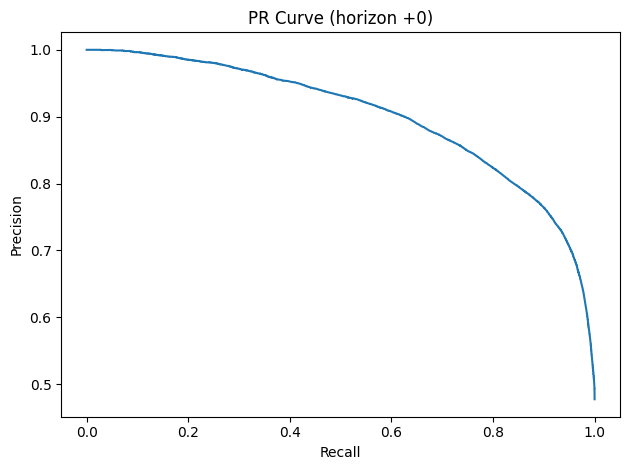

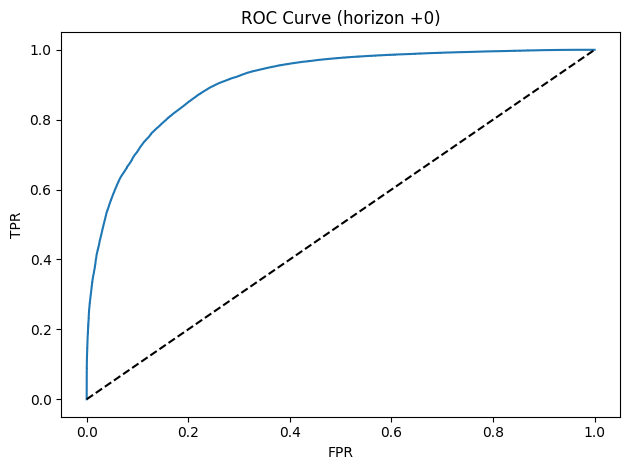

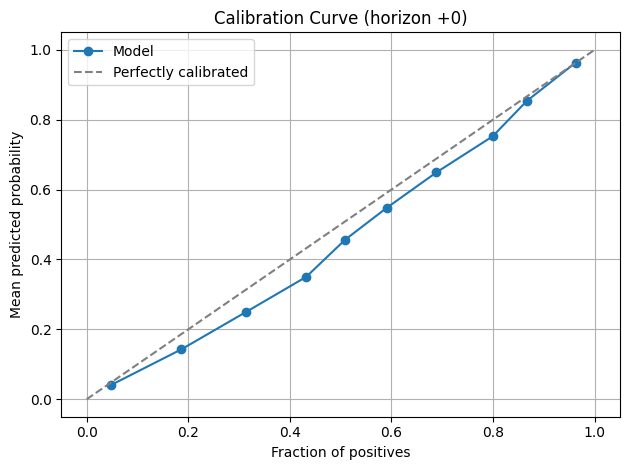

Saved conformal calibrator for horizon +1 to: output/models_bc_weekly/xgb_bc_h1_conformal.pkl
Calibration coverage on held-out set for horizon +1: 0.816
=== Evaluation for horizon +1 weeks ===
              precision    recall  f1-score   support

           0       0.76      0.80      0.78     83114
           1       0.77      0.73      0.75     75579

    accuracy                           0.77    158693
   macro avg       0.77      0.77      0.77    158693
weighted avg       0.77      0.77      0.77    158693

ROC AUC: 0.8460
PR AUC: 0.8410
[[66760 16354]
 [20596 54983]]
Brier Score (horizon +1): 0.1588
Expected Calibration Error (ECE) (horizon +1): 0.0093


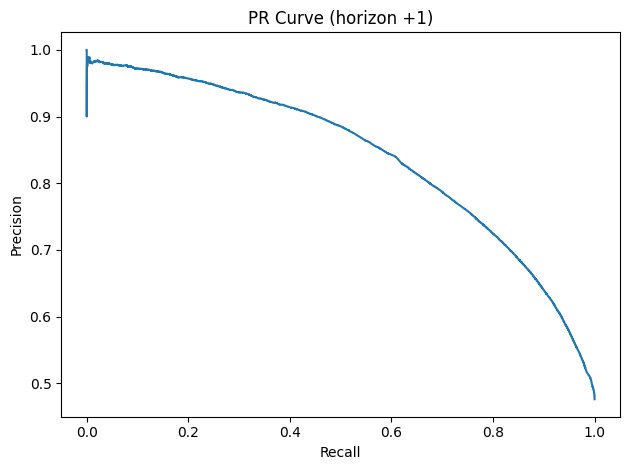

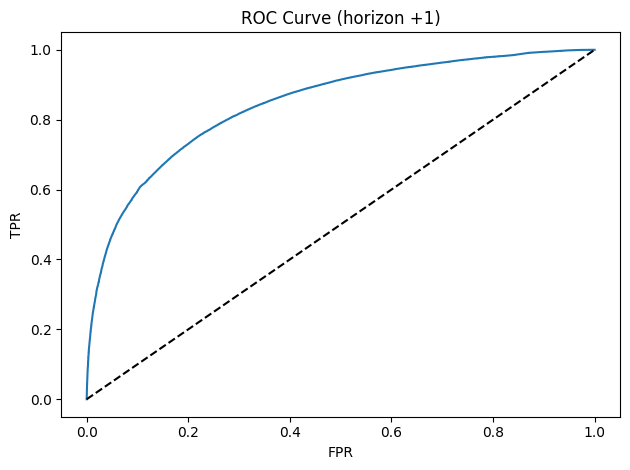

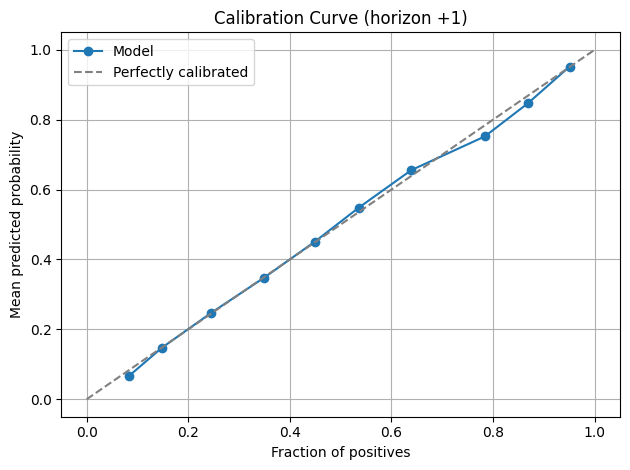

Saved conformal calibrator for horizon +2 to: output/models_bc_weekly/xgb_bc_h2_conformal.pkl
Calibration coverage on held-out set for horizon +2: 0.749
=== Evaluation for horizon +2 weeks ===
              precision    recall  f1-score   support

           0       0.72      0.79      0.76     79255
           1       0.75      0.67      0.71     72276

    accuracy                           0.73    151531
   macro avg       0.74      0.73      0.73    151531
weighted avg       0.74      0.73      0.73    151531

ROC AUC: 0.8147
PR AUC: 0.7979
[[62987 16268]
 [23969 48307]]
Brier Score (horizon +2): 0.1762
Expected Calibration Error (ECE) (horizon +2): 0.0270


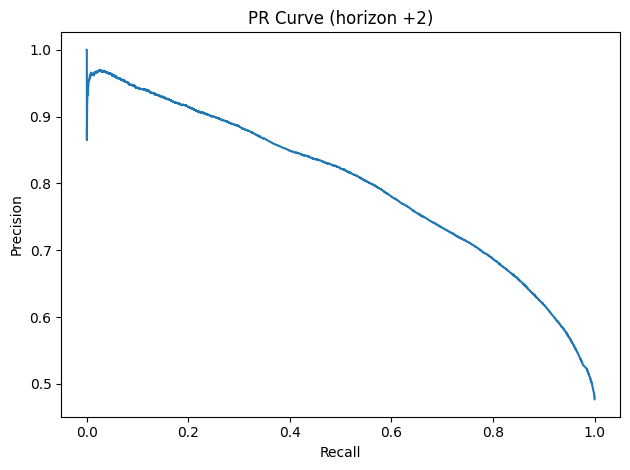

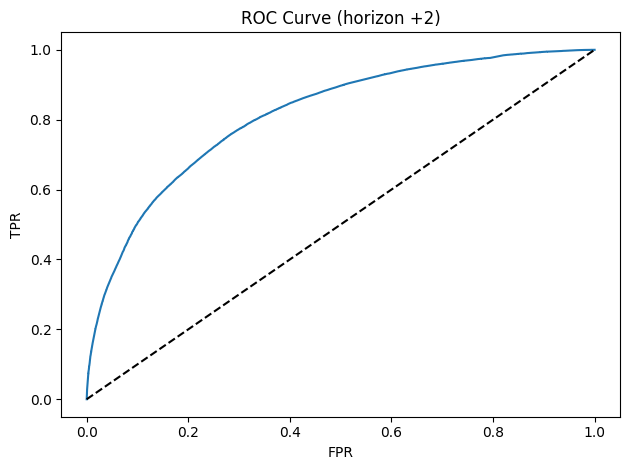

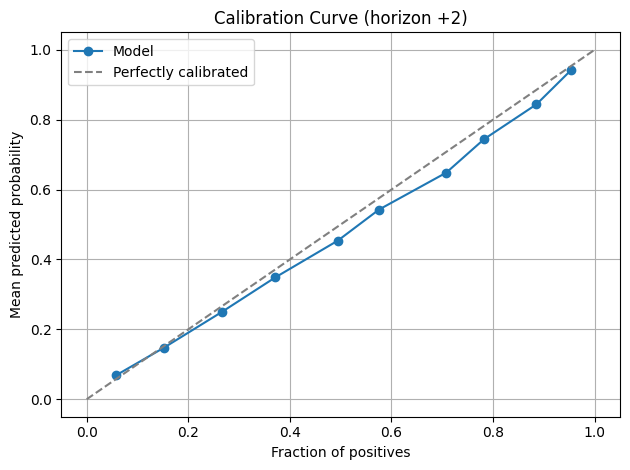

Saved conformal calibrator for horizon +3 to: output/models_bc_weekly/xgb_bc_h3_conformal.pkl
Calibration coverage on held-out set for horizon +3: 0.802
=== Evaluation for horizon +3 weeks ===
              precision    recall  f1-score   support

           0       0.73      0.79      0.76     75138
           1       0.75      0.68      0.71     69402

    accuracy                           0.74    144540
   macro avg       0.74      0.74      0.74    144540
weighted avg       0.74      0.74      0.74    144540

ROC AUC: 0.8132
PR AUC: 0.8002
[[59343 15795]
 [22092 47310]]
Brier Score (horizon +3): 0.1762
Expected Calibration Error (ECE) (horizon +3): 0.0171


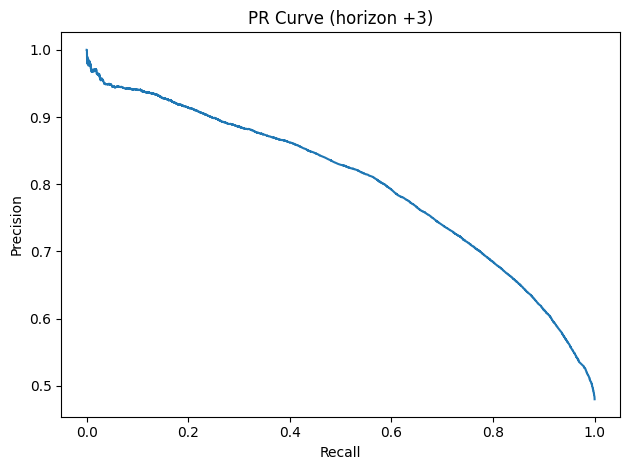

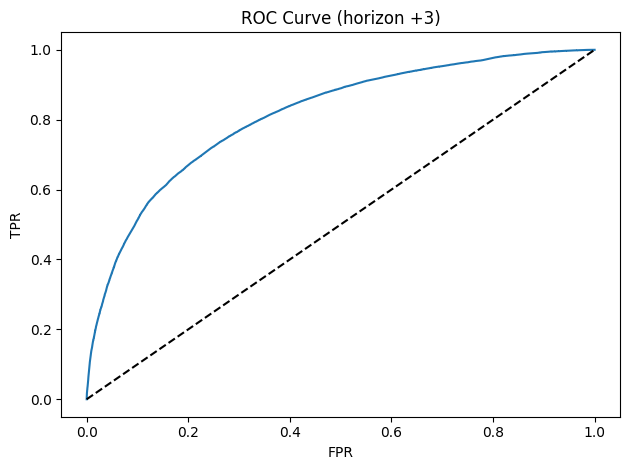

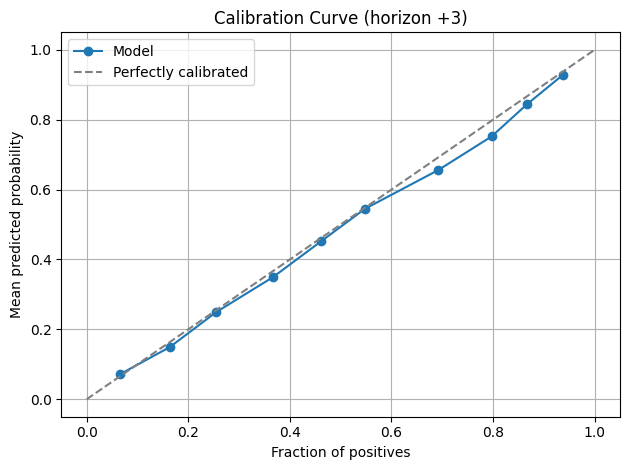

Saved conformal calibrator for horizon +4 to: output/models_bc_weekly/xgb_bc_h4_conformal.pkl
Calibration coverage on held-out set for horizon +4: 0.798
=== Evaluation for horizon +4 weeks ===
              precision    recall  f1-score   support

           0       0.73      0.78      0.75     71596
           1       0.74      0.69      0.71     66071

    accuracy                           0.74    137667
   macro avg       0.74      0.73      0.73    137667
weighted avg       0.74      0.74      0.73    137667

ROC AUC: 0.8109
PR AUC: 0.7917
[[55726 15870]
 [20522 45549]]
Brier Score (horizon +4): 0.1774
Expected Calibration Error (ECE) (horizon +4): 0.0212


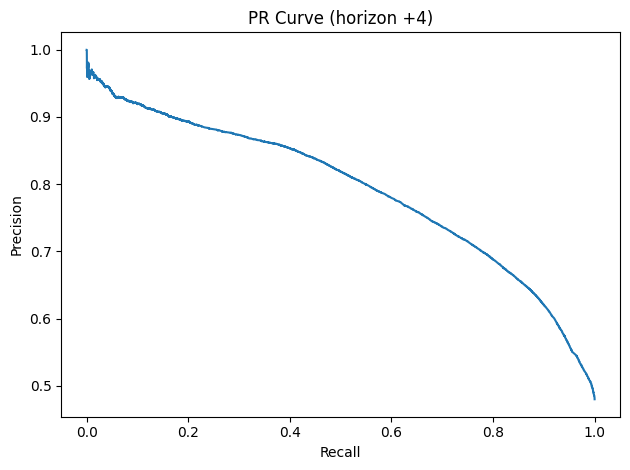

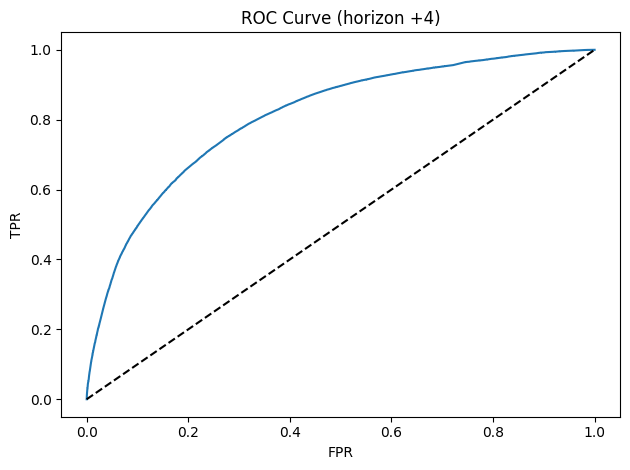

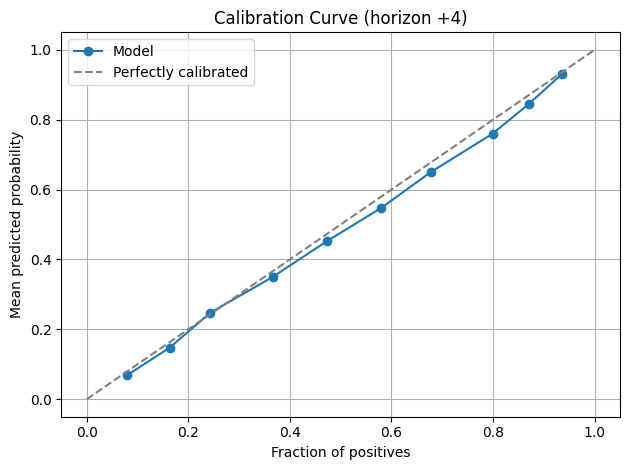

In [ ]:
evaluate_horizon_models_with_mapie(horizons=horizons, calibration_size=0.2, alpha=0.1)

In [ ]:
df_recommend = predict_current_week_and_recommend(models, threshold=0.6, lower_bound=0.5)

Saved recommendations to: output/recommendations.parquet


In [ ]:
len(df_recommend)

147

In [ ]:
print((df_recommend["recommended_week"] != -1).sum())

100


In [ ]:
print(df_recommend['recommended_week'].value_counts())

shape: (5, 2)
┌──────────────────┬───────┐
│ recommended_week ┆ count │
│ ---              ┆ ---   │
│ i64              ┆ u32   │
╞══════════════════╪═══════╡
│ 4                ┆ 4     │
│ -1               ┆ 47    │
│ 2                ┆ 1     │
│ 1                ┆ 67    │
│ 3                ┆ 28    │
└──────────────────┴───────┘


In [ ]:
shap_analysis(models)

In [ ]:
save_shifted_datasets(horizons)

Saved shifted dataset for horizon +1 weeks to: output/shifted_bc_weekly/h1.parquet
Saved shifted dataset for horizon +2 weeks to: output/shifted_bc_weekly/h2.parquet
Saved shifted dataset for horizon +3 weeks to: output/shifted_bc_weekly/h3.parquet
Saved shifted dataset for horizon +4 weeks to: output/shifted_bc_weekly/h4.parquet


In [ ]:
models = train_horizon_models(horizons, time_budget=30)

[flaml.automl.logger: 06-20 07:16:57] {1752} INFO - task = classification
[flaml.automl.logger: 06-20 07:16:57] {1763} INFO - Evaluation method: holdout
[flaml.automl.logger: 06-20 07:16:59] {1862} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 06-20 07:16:59] {1979} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 06-20 07:16:59] {2282} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 06-20 07:17:00] {2417} INFO - Estimated sufficient time budget=318915s. Estimated necessary time budget=319s.
[flaml.automl.logger: 06-20 07:17:00] {2466} INFO -  at 2.9s,	estimator xgboost's best error=0.3602,	best estimator xgboost's best error=0.3602
[flaml.automl.logger: 06-20 07:17:00] {2282} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 06-20 07:17:00] {2466} INFO -  at 2.9s,	estimator xgboost's best error=0.3429,	best estimator xgboost's best error=0.3429
[flaml.automl.logger: 06-20 07:17:00] {2282} INFO - iteration 2

Saved conformal calibrator for horizon +1 to: output/models_bc_weekly/xgb_bc_h1_conformal.pkl
Calibration coverage on held-out set for horizon +1: 0.750
=== Evaluation for horizon +1 weeks ===
              precision    recall  f1-score   support

           0       0.75      0.82      0.78     83114
           1       0.78      0.71      0.74     75579

    accuracy                           0.76    158693
   macro avg       0.77      0.76      0.76    158693
weighted avg       0.77      0.76      0.76    158693

ROC AUC: 0.8442
PR AUC: 0.8385
[[67886 15228]
 [22218 53361]]


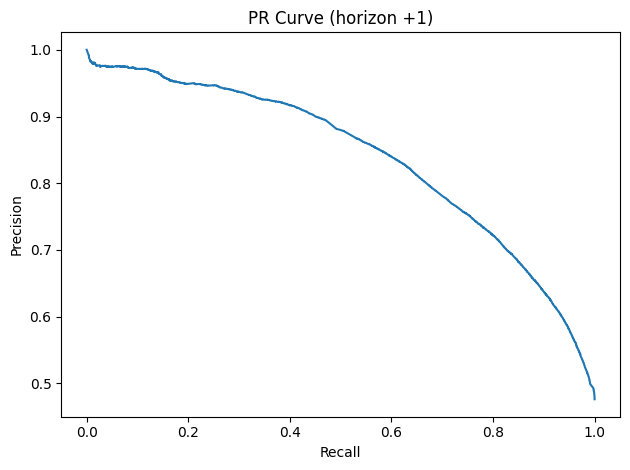

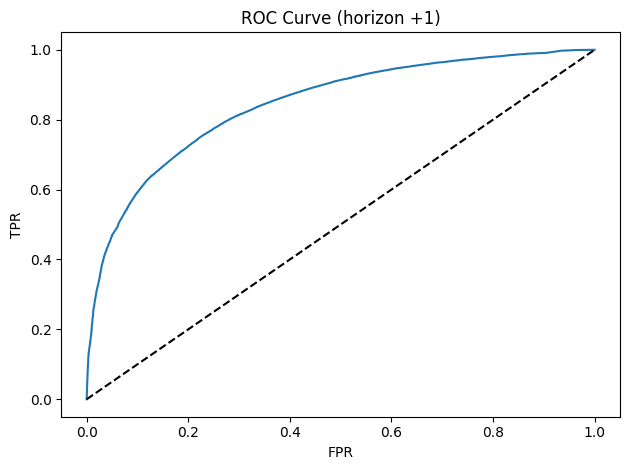

Saved conformal calibrator for horizon +2 to: output/models_bc_weekly/xgb_bc_h2_conformal.pkl
Calibration coverage on held-out set for horizon +2: 0.728
=== Evaluation for horizon +2 weeks ===
              precision    recall  f1-score   support

           0       0.72      0.80      0.76     79255
           1       0.75      0.66      0.70     72276

    accuracy                           0.73    151531
   macro avg       0.74      0.73      0.73    151531
weighted avg       0.74      0.73      0.73    151531

ROC AUC: 0.8141
PR AUC: 0.7973
[[63558 15697]
 [24572 47704]]


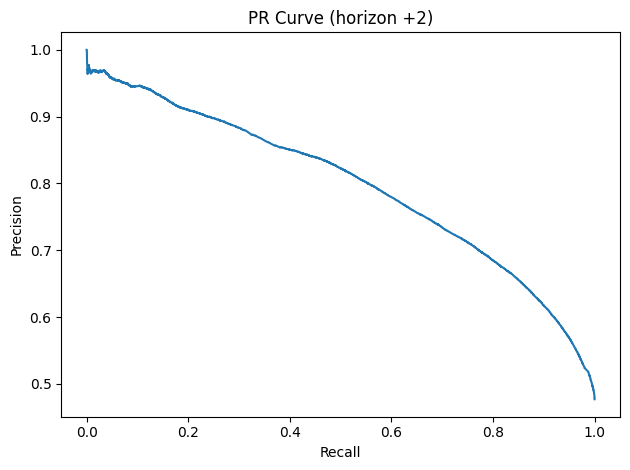

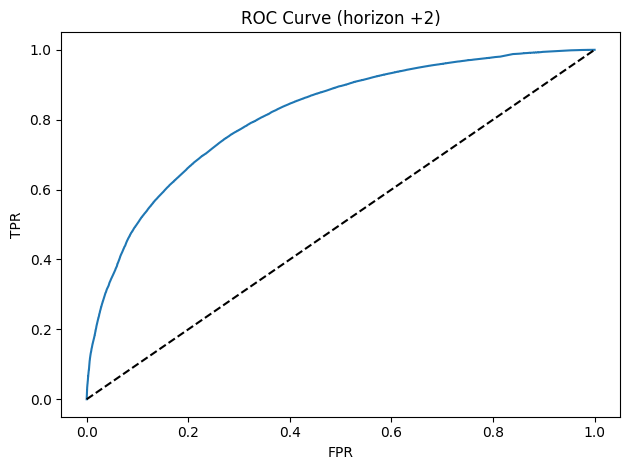

Saved conformal calibrator for horizon +3 to: output/models_bc_weekly/xgb_bc_h3_conformal.pkl
Calibration coverage on held-out set for horizon +3: 0.740
=== Evaluation for horizon +3 weeks ===
              precision    recall  f1-score   support

           0       0.72      0.82      0.76     75138
           1       0.77      0.65      0.70     69402

    accuracy                           0.74    144540
   macro avg       0.74      0.73      0.73    144540
weighted avg       0.74      0.74      0.73    144540

ROC AUC: 0.8130
PR AUC: 0.7998
[[61323 13815]
 [24277 45125]]


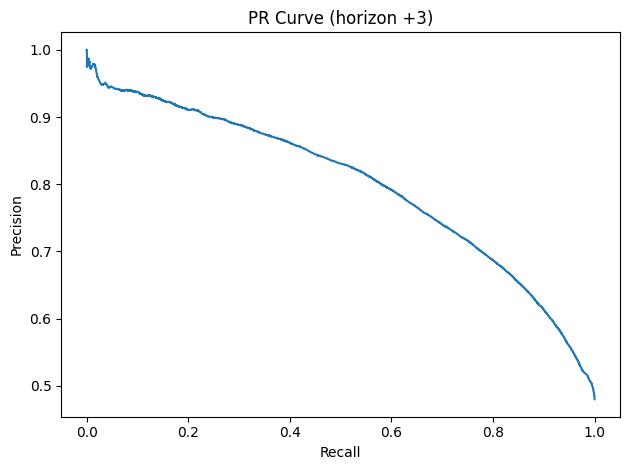

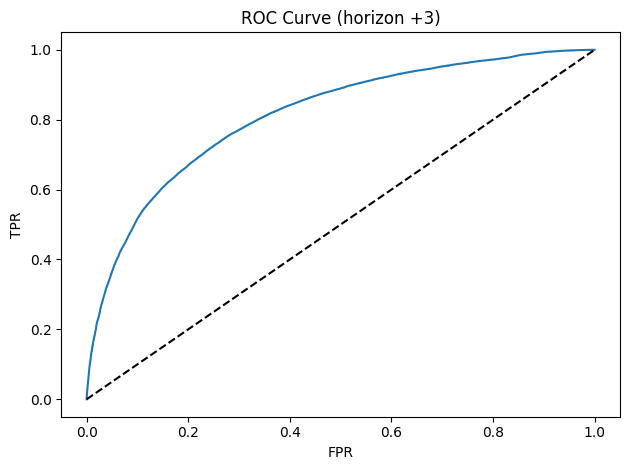

Saved conformal calibrator for horizon +4 to: output/models_bc_weekly/xgb_bc_h4_conformal.pkl
Calibration coverage on held-out set for horizon +4: 0.728
=== Evaluation for horizon +4 weeks ===
              precision    recall  f1-score   support

           0       0.73      0.78      0.76     71596
           1       0.75      0.69      0.72     66071

    accuracy                           0.74    137667
   macro avg       0.74      0.74      0.74    137667
weighted avg       0.74      0.74      0.74    137667

ROC AUC: 0.8123
PR AUC: 0.7917
[[56194 15402]
 [20619 45452]]


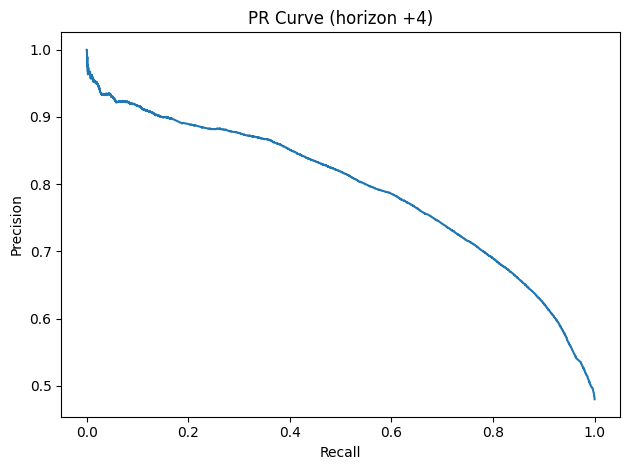

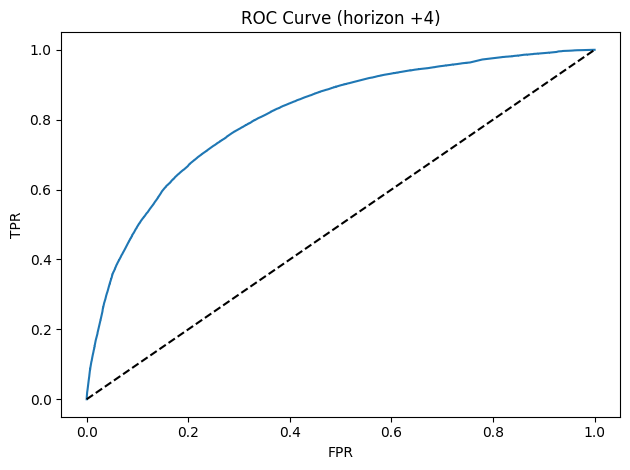

In [ ]:
evaluate_horizon_models_with_mapie(models, calibration_size=0.2, alpha=0.1)

In [ ]:
df_recommend = predict_current_week_and_recommend(models, threshold=0.6, lower_bound=0.5)

Saved recommendations to: output/recommendations.parquet


In [ ]:
len(df_recommend)

147

In [ ]:
print((df_recommend["recommended_week"] != -1).sum())

63


In [ ]:
print(df_recommend['recommended_week'].value_counts())

shape: (4, 2)
┌──────────────────┬───────┐
│ recommended_week ┆ count │
│ ---              ┆ ---   │
│ i64              ┆ u32   │
╞══════════════════╪═══════╡
│ 1                ┆ 46    │
│ 4                ┆ 3     │
│ 3                ┆ 14    │
│ -1               ┆ 84    │
└──────────────────┴───────┘


In [ ]:
shap_analysis(models)

Top 10 SHAP for horizon +1:
  billing_service_type_domestic_assistance_count_4_week_sum: 0.3698
  service_type_supertype_other: 0.3358
  amount_4_week_sum: 0.2048
  service_type_supertype_other_count_4_week_sum: 0.1854
  billing_service_type_social_support_individual_count_4_week_sum: 0.1686
  billing_service_type_domestic_assistance: 0.0746
  billing_service_type_fees_count_4_week_sum: 0.0712
  duration_sum: 0.0600
  employee_category_supertype_other_count_4_week_sum: 0.0568
  billing_service_type_physiotherapist_count_4_week_sum: 0.0556
Top 10 SHAP for horizon +2:
  billing_service_type_domestic_assistance_count_4_week_sum: 0.3672
  amount_4_week_sum: 0.1597
  service_type_supertype_other_count_4_week_sum: 0.1428
  billing_service_type_social_support_individual_count_4_week_sum: 0.1399
  employee_category_supertype_other_count_4_week_sum: 0.0932
  funder_level_domestic_assistance_count_4_week_sum: 0.0751
  amount_sum: 0.0703
  duration_4_week_sum: 0.0592
  billable_duration_sum: 0.05

## Time Horizons - tune.run()

In [ ]:
# TODO currently getting search space warning, need to look into

In [ ]:
from pathlib import Path
from typing import Final, Tuple, List, Dict
import polars as pl
import numpy as np
import pickle
import matplotlib.pyplot as plt
from beartype import beartype
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, average_precision_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split
from mapie.classification import SplitConformalClassifier
import shap
from datetime import datetime, date
from flaml import AutoML, tune
import xgboost as xgb

horizons = [1, 2, 3, 4]

# Paths
OUTPUT_DIR: Final[Path] = Path("output")
DATA_PATH: Final[Path] = Path("output/hcs_weekly_bc_data_with_4w.parquet")
# Directories
SHIFTED_DIR: Final[Path] = Path("output/shifted_bc_weekly")
MODEL_DIR: Final[Path]   = Path("output/models_bc_weekly")
# Ensure dirs exist
SHIFTED_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Split date for train/test
SPLIT_DATE_STR: Final[str] = "2024-09-01"
SPLIT_DATE: Final[date]    = datetime.strptime(SPLIT_DATE_STR, "%Y-%m-%d").date()

@beartype
def save_shifted_datasets(horizons: List[int]) -> None:
    df = pl.read_parquet(DATA_PATH)
    df = _ensure_date(df)
    for h in horizons:
        shifted = (
            df.sort(["client_id_joint", "event_date"])
              .with_columns(
                  pl.col("target").shift(-h).over("client_id_joint").alias(f"target_t+{h}")
              )
              .filter(pl.col(f"target_t+{h}").is_not_null())
              .drop("target")
        )
        out_path = SHIFTED_DIR / f"h{h}.parquet"
        shifted.write_parquet(out_path)
        print(f"Saved shifted dataset for horizon +{h} weeks to: {out_path}")

@beartype
def prepare_classification(
    df: pl.DataFrame,
    target_col: str
) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Build feature matrix X and label vector y, dynamically recasting non-numeric columns or dropping them with warnings.

    Excludes: client_id_joint, event_date, and the shifted target.
    Attempts to cast any other columns to Float64; if casting fails, drops that column and prints a warning.
    """
    exclude_cols = {"client_id_joint", "event_date", target_col}
    feature_cols: List[str] = []
    cast_df = df
    dropped: List[str] = []

    for c in df.columns:
        if c in exclude_cols:
            continue
        dtype = df[c].dtype
        if dtype in (pl.Float64, pl.Int64):
            feature_cols.append(c)
        else:
            # try to cast to Float64
            try:
                cast_series = df[c].cast(pl.Float64)
                # check if cast introduced nulls where there were values
                orig_non_null = df[c].drop_nulls().len()
                cast_non_null = cast_series.drop_nulls().len()
                if cast_non_null < orig_non_null:
                    raise ValueError(f"Casting {c} introduced nulls")
                cast_df = cast_df.with_columns([cast_series.alias(c)])
                feature_cols.append(c)
            except Exception as e:
                dropped.append(c)
                print(f"Warning: dropping column '{c}' (could not cast to numeric): {e}")

    # Select final features
    X = cast_df.select(feature_cols).to_numpy()
    y = cast_df.select(target_col).to_series().to_numpy().astype(int)
    if dropped:
        print(f"Dropped columns due to non-numeric types or cast failures: {dropped}")
    return X, y, feature_cols

@beartype
def train_horizon_models(horizons: List[int], time_budget: int = 30) -> Dict[int, Tuple[XGBClassifier, List[str]]]:
    models: Dict[int, Tuple[XGBClassifier, List[str]]] = {}
    for h in horizons:
        df_h = pl.read_parquet(SHIFTED_DIR / f'h{h}.parquet')
        df_h = _ensure_date(df_h)
        train_df = df_h.filter(pl.col('event_date') < SPLIT_DATE)
        X, y, feature_cols = prepare_classification(train_df, f'target_t+{h}')

        # Chronological validation split for tuning (time-based)
        train_df_sorted = train_df.sort("event_date")
        n_total = train_df_sorted.height
        n_val = int(0.2 * n_total)
        val_df = train_df_sorted.tail(n_val)
        train_split_df = train_df_sorted.head(n_total - n_val)
        X_train, y_train, _ = prepare_classification(train_split_df, f"target_t+{h}")
        X_val,   y_val,   _ = prepare_classification(val_df,         f"target_t+{h}")

        def trainable(config):
            model = XGBClassifier(
                objective='binary:logistic',
                tree_method='hist',
                eval_metric='auc',
                learning_rate=config['learning_rate'],
                max_depth=int(config['max_depth']),
                n_estimators=int(config['n_estimators']),
                subsample=config['subsample'],
                colsample_bytree=config['colsample_bytree'],
                random_state=42
            )
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
            preds = model.predict_proba(X_val)[:, 1]
            pr_auc = average_precision_score(y_val, preds)
            tune.report(pr_auc=pr_auc)

        search_space = {
            'learning_rate': tune.loguniform(lower=1e-3, upper=1e-1),
            'max_depth': tune.randint(lower=3, upper=20),
            'n_estimators': tune.lograndint(lower=50, upper=2000),
            'subsample': tune.uniform(lower=0.5, upper=1.0),
            'colsample_bytree': tune.uniform(lower=0.5, upper=1.0),
        }

        analysis = tune.run(
            trainable,
            config=search_space,
            metric='pr_auc',
            mode='max',
            time_budget_s=time_budget,
            num_samples=-1,
            verbose=1
        )

        best_config = analysis.get_best_config(metric='pr_auc', mode='max')
        if best_config is None:
            print(f"Warning: No best config found for horizon +{h}. Skipping this horizon.")
            continue
        best_model = XGBClassifier(
            objective='binary:logistic',
            tree_method='hist',
            eval_metric='auc',
            learning_rate=best_config['learning_rate'],
            max_depth=int(best_config['max_depth']),
            n_estimators=int(best_config['n_estimators']),
            subsample=best_config['subsample'],
            colsample_bytree=best_config['colsample_bytree'],
            random_state=42
        )
        best_model.fit(X, y, eval_set=[(X_val, y_val)], verbose=False)

        model_path = MODEL_DIR / f'xgb_bc_h{h}.pkl'
        with open(model_path, 'wb') as f_model:
            pickle.dump(best_model, f_model)

        models[h] = (best_model, feature_cols)
        print(f'Tuned and saved horizon +{h} model to: {model_path}')

    return models

@beartype
def evaluate_horizon_models_with_mapie(
    models: Dict[int, Tuple[XGBClassifier, List[str]]],
    alpha: float = 0.1,
    calibration_size: float = 0.2
) -> None:
    """
    Fit conformal calibrator on held-out subset of training data, evaluate calibration quality,
    and evaluate on test set using a fixed confidence level (1-alpha).
    """
    for h, (clf, feature_cols) in models.items():
        df_h = pl.read_parquet(SHIFTED_DIR / f"h{h}.parquet")
        df_h = _ensure_date(df_h)

        # Split data by date
        train_df = df_h.filter(pl.col("event_date") < SPLIT_DATE)
        test_df  = df_h.filter(pl.col("event_date") >= SPLIT_DATE)

        # Chronological calibration split from training to avoid time-based leakage
        train_df_sorted = train_df.sort("event_date")
        n_total = train_df_sorted.height
        n_cal = int(calibration_size * n_total)
        cal_df = train_df_sorted.tail(n_cal)
        hold_df = train_df_sorted.head(n_total - n_cal)

        X_cal, y_cal, _ = prepare_classification(cal_df, f"target_t+{h}")
        X_hold, y_hold, _ = prepare_classification(hold_df, f"target_t+{h}")

        # Fit and save conformal calibrator with confidence level
        cl = 1 - alpha
        conformal = SplitConformalClassifier(
            estimator=clf,
            confidence_level=cl,
            random_state=42,
            n_jobs=-1
        )
        conformal.conformalize(X_cal, y_cal)
        cal_path = MODEL_DIR / f"xgb_bc_h{h}_conformal.pkl"
        with open(cal_path, "wb") as f_cal:
            pickle.dump(conformal, f_cal)
        print(f"Saved conformal calibrator for horizon +{h} to: {cal_path}")

        # Evaluate calibration hold-out coverage
        y_hold_sets = conformal.predict(X_hold)
        if isinstance(y_hold_sets, np.ndarray) and y_hold_sets.ndim == 1:
            hold_coverage = np.mean(y_hold_sets == y_hold)
        else:
            hold_coverage = np.mean([y_hold[i] in y_hold_sets[i] for i in range(len(y_hold_sets))])
        print(f"Calibration coverage on held-out set for horizon +{h}: {hold_coverage:.3f}")

        # Evaluate on test set
        X_test, y_test, _ = prepare_classification(test_df, f"target_t+{h}")
        y_test_sets = conformal.predict(X_test)
        y_proba      = clf.predict_proba(X_test)[:, 1]
        if isinstance(y_test_sets, np.ndarray) and y_test_sets.ndim == 1:
            y_pred = y_test_sets.astype(int)
        else:
            y_pred = np.array([
                1 in s if isinstance(s, (set, list, tuple)) else bool(s)
                for s in y_test_sets
            ])

        print(f"=== Evaluation for horizon +{h} weeks ===")
        print(classification_report(y_test, y_pred))
        print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
        print(f"PR AUC: {average_precision_score(y_test, y_proba):.4f}")
        print(confusion_matrix(y_test, y_pred))

        # Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        plt.figure()
        plt.plot(recall, precision, label="AUC-PR")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"PR Curve (horizon +{h})")
        plt.tight_layout()
        plt.show()

        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label="ROC")
        plt.plot([0,1],[0,1], 'k--')
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title(f"ROC Curve (horizon +{h})")
        plt.tight_layout()
        plt.show()

@beartype
def recommend_week_from_probabilities(
    probas: Dict[int, np.ndarray],
    lowers: Dict[int, np.ndarray],
    threshold: float = 0.6,
    lower_bound: float = 0.5
) -> List[int]:
    """
    Recommend the horizon with the highest week number that meets both probability
    and conformal lower-bound criteria.
    """
    recs: List[int] = []
    n = len(next(iter(probas.values())))
    for i in range(n):
        valid = [h for h in probas if probas[h][i] > threshold and lowers[h][i] > lower_bound]
        recs.append(max(valid) if valid else -1)
    return recs

@beartype
def predict_current_week_and_recommend(
    models: Dict[int, Tuple[XGBClassifier, List[str]]],
    threshold: float = 0.6,
    lower_bound: float = 0.5
) -> pl.DataFrame:
    """
    Predict current probabilities and recommend horizon using saved conformal calibrators.
    """
    latest_df = pl.read_parquet(DATA_PATH)
    latest_df = _ensure_date(latest_df)
    last_date = latest_df.select(pl.col("event_date")).max().item()
    subset = latest_df.filter(pl.col("event_date") == last_date)
    ids_df = subset.select(["client_id_joint", "event_date"])

    probas: Dict[int, np.ndarray] = {}
    lowers: Dict[int, np.ndarray] = {}
    for h, (clf, feature_cols) in models.items():
        X = subset.select(feature_cols).to_numpy()
        cal_path = MODEL_DIR / f"xgb_bc_h{h}_conformal.pkl"
        with open(cal_path, "rb") as f_cal:
            conformal = pickle.load(f_cal)

        y_sets = conformal.predict(X)
        probas[h] = clf.predict_proba(X)[:, 1]
        if isinstance(y_sets, np.ndarray) and y_sets.ndim == 1:
            lowers[h] = y_sets.astype(int)
        else:
            lowers[h] = np.array([
                1 in s if isinstance(s, (set, list, tuple)) else bool(s)
                for s in y_sets
            ])

    recs = recommend_week_from_probabilities(probas, lowers, threshold, lower_bound)
    df_out = ids_df.with_columns([
        pl.Series(name=f"proba_t+{h}", values=probas[h]) for h in horizons
    ] + [
        pl.Series(name=f"lower_t+{h}", values=lowers[h]) for h in horizons
    ] + [
        pl.Series(name="recommended_week", values=recs)
    ])

    # Save recommendations to parquet
    recommendations_path = OUTPUT_DIR / "recommendations.parquet"
    df_out.write_parquet(recommendations_path)
    print(f"Saved current-week recommendations to: {recommendations_path}")
    return df_out

@beartype
def shap_analysis(models: Dict[int, Tuple[XGBClassifier, List[str]]]) -> None:
    for h, (clf, feat_cols) in models.items():
        df_h = pl.read_parquet(SHIFTED_DIR / f"h{h}.parquet")
        df_h = _ensure_date(df_h)
        test_df = df_h.filter(pl.col("event_date") >= SPLIT_DATE)
        X_test, _, feature_names = prepare_classification(test_df, f"target_t+{h}")

        # Fast SHAP via XGBoost contribs
        dmat = xgb.DMatrix(X_test, feature_names=feature_names)
        contribs = clf.get_booster().predict(dmat, pred_contribs=True)
        shap_vals = contribs[:, :-1]

        shap_abs = np.abs(shap_vals).mean(axis=0)
        top_idx = np.argsort(shap_abs)[-10:][::-1]
        top_feats = [feature_names[i] for i in top_idx]
        top_vals = shap_abs[top_idx]

        print(f"Top 10 SHAP for horizon +{h}:")
        for name, val in zip(top_feats, top_vals):
            print(f"  {name}: {val:.4f}")

        shap.summary_plot(
            shap_vals,
            X_test,
            feature_names=feature_names,
            max_display=10,
            show=False
        )
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / f"shap_summary_h{h}.png")
        plt.close()

        plt.figure()
        plt.barh(top_feats, top_vals)
        plt.gca().invert_yaxis()
        plt.title(f"SHAP Top 10 Feature Importances (+{h})")
        plt.xlabel("Mean |SHAP value|")
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / f"shap_bar_h{h}.png")
        plt.close()

@beartype
def _ensure_date(df: pl.DataFrame) -> pl.DataFrame:
    if df["event_date"].dtype == pl.Date:
        return df
    if df["event_date"].dtype == pl.Utf8:
        return df.with_columns(
            pl.col("event_date").str.strptime(pl.Date, "%Y-%m-%d").alias("event_date")
        )
    return df.with_columns(
        pl.col("event_date").cast(pl.Date).alias("event_date")
    )

In [ ]:
save_shifted_datasets(horizons)

Saved shifted dataset for horizon +1 weeks to: output/shifted_bc_weekly/h1.parquet
Saved shifted dataset for horizon +2 weeks to: output/shifted_bc_weekly/h2.parquet
Saved shifted dataset for horizon +3 weeks to: output/shifted_bc_weekly/h3.parquet
Saved shifted dataset for horizon +4 weeks to: output/shifted_bc_weekly/h4.parquet


In [ ]:
models = train_horizon_models(horizons, time_budget=30)

[flaml.tune.logger: 06-20 07:02:01] {583} INFO - Using search algorithm BlendSearch.


2025-06-20 07:02:01,804	WARNING optuna_search.py:342 -- You passed a `space` parameter to OptunaSearch that contained unresolved search space definitions. OptunaSearch should however be instantiated with fully configured search spaces only. To use Ray Tune's automatic search space conversion, pass the space definition as part of the `param_space` argument to `tune.Tuner()` instead.
[I 2025-06-20 07:02:01,806] A new study created in memory with name: optuna


[flaml.tune.logger: 06-20 07:02:01] {891} INFO - trial 1 config: {'learning_rate': 0.0015662610420278322, 'max_depth': 5, 'n_estimators': 190, 'subsample': 0.6843297251340599, 'colsample_bytree': 0.877743449018298}
[flaml.tune.logger: 06-20 07:02:10] {891} INFO - trial 2 config: {'learning_rate': 0.034885205571560766, 'max_depth': 3, 'n_estimators': 516, 'subsample': 0.8744019412693059, 'colsample_bytree': 0.7492535061512953}
[flaml.tune.logger: 06-20 07:02:30] {891} INFO - trial 3 config: {'learning_rate': 0.002815744802026466, 'max_depth': 6, 'n_estimators': 825, 'subsample': 0.5845554182812678, 'colsample_bytree': 0.5441699070870052}
Tuned and saved horizon +1 model to: output/models_bc_weekly/xgb_bc_h1.pkl
[flaml.tune.logger: 06-20 07:04:31] {583} INFO - Using search algorithm BlendSearch.


2025-06-20 07:04:31,256	WARNING optuna_search.py:342 -- You passed a `space` parameter to OptunaSearch that contained unresolved search space definitions. OptunaSearch should however be instantiated with fully configured search spaces only. To use Ray Tune's automatic search space conversion, pass the space definition as part of the `param_space` argument to `tune.Tuner()` instead.
[I 2025-06-20 07:04:31,258] A new study created in memory with name: optuna


[flaml.tune.logger: 06-20 07:04:31] {891} INFO - trial 1 config: {'learning_rate': 0.0015662610420278322, 'max_depth': 5, 'n_estimators': 190, 'subsample': 0.6843297251340599, 'colsample_bytree': 0.877743449018298}
[flaml.tune.logger: 06-20 07:04:39] {891} INFO - trial 2 config: {'learning_rate': 0.034885205571560766, 'max_depth': 3, 'n_estimators': 516, 'subsample': 0.8744019412693059, 'colsample_bytree': 0.7492535061512953}
[flaml.tune.logger: 06-20 07:04:57] {891} INFO - trial 3 config: {'learning_rate': 0.002815744802026466, 'max_depth': 6, 'n_estimators': 825, 'subsample': 0.5845554182812678, 'colsample_bytree': 0.5441699070870052}
Tuned and saved horizon +2 model to: output/models_bc_weekly/xgb_bc_h2.pkl
[flaml.tune.logger: 06-20 07:06:32] {583} INFO - Using search algorithm BlendSearch.


2025-06-20 07:06:32,474	WARNING optuna_search.py:342 -- You passed a `space` parameter to OptunaSearch that contained unresolved search space definitions. OptunaSearch should however be instantiated with fully configured search spaces only. To use Ray Tune's automatic search space conversion, pass the space definition as part of the `param_space` argument to `tune.Tuner()` instead.
[I 2025-06-20 07:06:32,475] A new study created in memory with name: optuna


[flaml.tune.logger: 06-20 07:06:32] {891} INFO - trial 1 config: {'learning_rate': 0.0015662610420278322, 'max_depth': 5, 'n_estimators': 190, 'subsample': 0.6843297251340599, 'colsample_bytree': 0.877743449018298}
[flaml.tune.logger: 06-20 07:06:41] {891} INFO - trial 2 config: {'learning_rate': 0.034885205571560766, 'max_depth': 3, 'n_estimators': 516, 'subsample': 0.8744019412693059, 'colsample_bytree': 0.7492535061512953}
[flaml.tune.logger: 06-20 07:07:00] {891} INFO - trial 3 config: {'learning_rate': 0.002815744802026466, 'max_depth': 6, 'n_estimators': 825, 'subsample': 0.5845554182812678, 'colsample_bytree': 0.5441699070870052}
Tuned and saved horizon +3 model to: output/models_bc_weekly/xgb_bc_h3.pkl
[flaml.tune.logger: 06-20 07:08:26] {583} INFO - Using search algorithm BlendSearch.


2025-06-20 07:08:26,317	WARNING optuna_search.py:342 -- You passed a `space` parameter to OptunaSearch that contained unresolved search space definitions. OptunaSearch should however be instantiated with fully configured search spaces only. To use Ray Tune's automatic search space conversion, pass the space definition as part of the `param_space` argument to `tune.Tuner()` instead.
[I 2025-06-20 07:08:26,318] A new study created in memory with name: optuna


[flaml.tune.logger: 06-20 07:08:26] {891} INFO - trial 1 config: {'learning_rate': 0.0015662610420278322, 'max_depth': 5, 'n_estimators': 190, 'subsample': 0.6843297251340599, 'colsample_bytree': 0.877743449018298}
[flaml.tune.logger: 06-20 07:08:37] {891} INFO - trial 2 config: {'learning_rate': 0.034885205571560766, 'max_depth': 3, 'n_estimators': 516, 'subsample': 0.8744019412693059, 'colsample_bytree': 0.7492535061512953}
Tuned and saved horizon +4 model to: output/models_bc_weekly/xgb_bc_h4.pkl


Saved conformal calibrator for horizon +1 to: output/models_bc_weekly/xgb_bc_h1_conformal.pkl
Calibration coverage on held-out set for horizon +1: 0.737
=== Evaluation for horizon +1 weeks ===
              precision    recall  f1-score   support

           0       0.72      0.86      0.78     83114
           1       0.81      0.63      0.71     75579

    accuracy                           0.75    158693
   macro avg       0.76      0.75      0.75    158693
weighted avg       0.76      0.75      0.75    158693

ROC AUC: 0.8314
PR AUC: 0.8254
[[71589 11525]
 [27941 47638]]


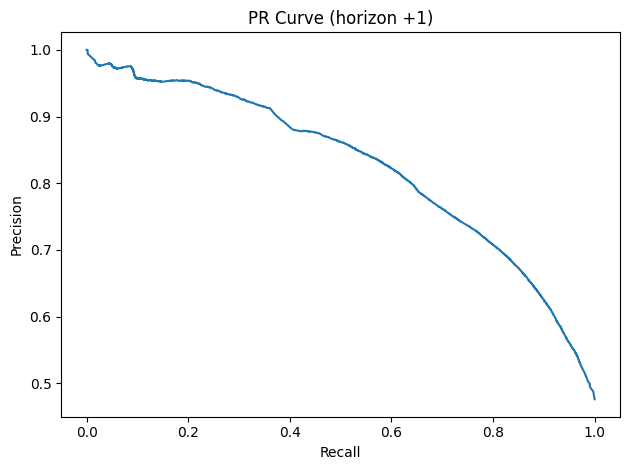

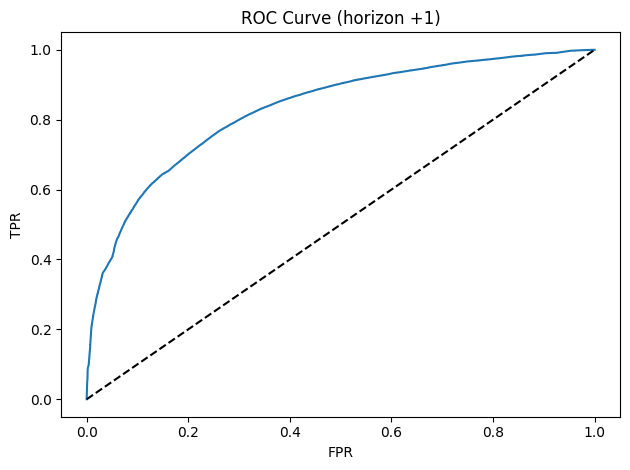

Saved conformal calibrator for horizon +2 to: output/models_bc_weekly/xgb_bc_h2_conformal.pkl
Calibration coverage on held-out set for horizon +2: 0.709
=== Evaluation for horizon +2 weeks ===
              precision    recall  f1-score   support

           0       0.70      0.83      0.76     79255
           1       0.77      0.61      0.68     72276

    accuracy                           0.72    151531
   macro avg       0.73      0.72      0.72    151531
weighted avg       0.73      0.72      0.72    151531

ROC AUC: 0.8005
PR AUC: 0.7818
[[65814 13441]
 [28316 43960]]


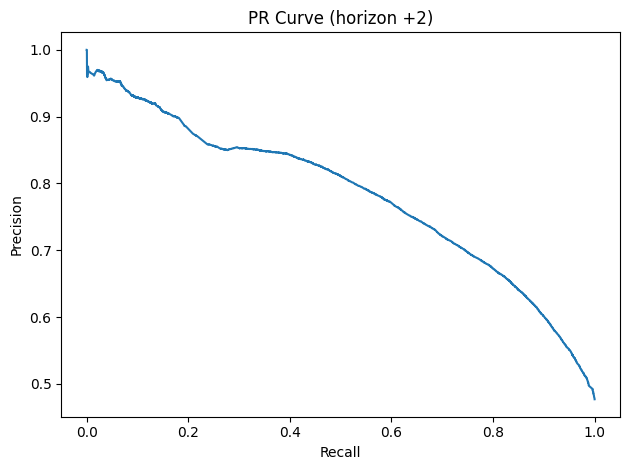

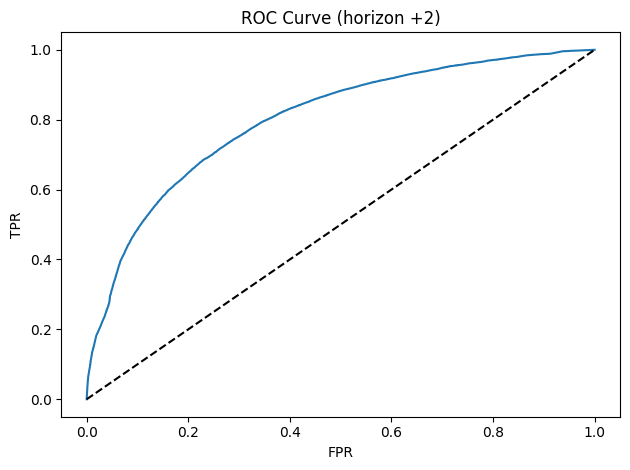

Saved conformal calibrator for horizon +3 to: output/models_bc_weekly/xgb_bc_h3_conformal.pkl
Calibration coverage on held-out set for horizon +3: 0.711
=== Evaluation for horizon +3 weeks ===
              precision    recall  f1-score   support

           0       0.69      0.85      0.76     75138
           1       0.78      0.59      0.67     69402

    accuracy                           0.72    144540
   macro avg       0.74      0.72      0.72    144540
weighted avg       0.74      0.72      0.72    144540

ROC AUC: 0.8010
PR AUC: 0.7872
[[63633 11505]
 [28252 41150]]


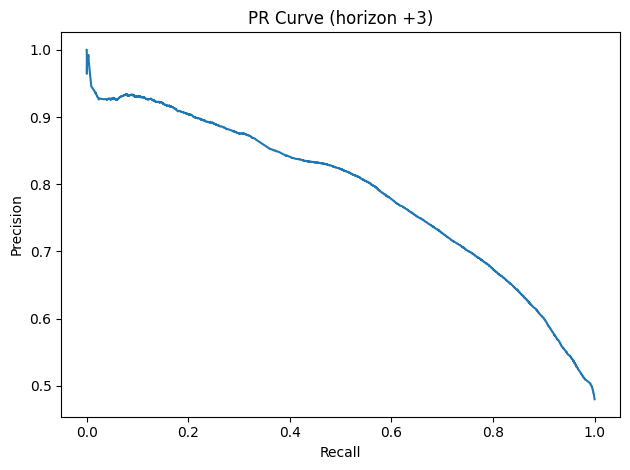

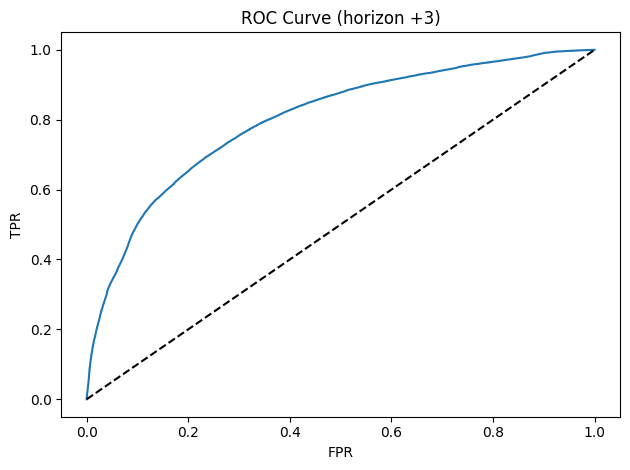

Saved conformal calibrator for horizon +4 to: output/models_bc_weekly/xgb_bc_h4_conformal.pkl
Calibration coverage on held-out set for horizon +4: 0.709
=== Evaluation for horizon +4 weeks ===
              precision    recall  f1-score   support

           0       0.71      0.80      0.75     71596
           1       0.75      0.65      0.69     66071

    accuracy                           0.73    137667
   macro avg       0.73      0.72      0.72    137667
weighted avg       0.73      0.73      0.72    137667

ROC AUC: 0.8017
PR AUC: 0.7756
[[56940 14656]
 [23133 42938]]


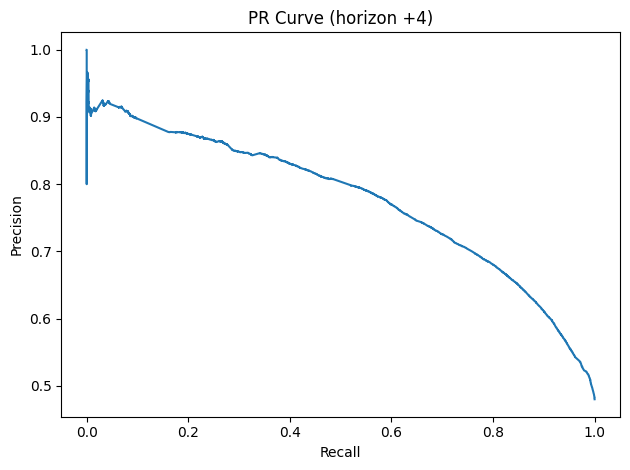

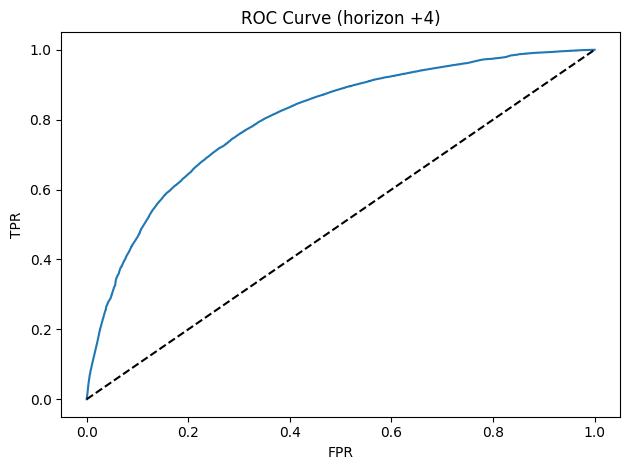

In [ ]:
evaluate_horizon_models_with_mapie(models, calibration_size=0.2, alpha=0.1)

In [ ]:
df_recommend = predict_current_week_and_recommend(models, threshold=0.6, lower_bound=0.5)

Saved current-week recommendations to: output/recommendations.parquet


In [ ]:
print(df_recommend['recommended_week'].value_counts())

shape: (4, 2)
┌──────────────────┬───────┐
│ recommended_week ┆ count │
│ ---              ┆ ---   │
│ i64              ┆ u32   │
╞══════════════════╪═══════╡
│ 4                ┆ 4     │
│ 1                ┆ 6     │
│ 3                ┆ 6     │
│ -1               ┆ 131   │
└──────────────────┴───────┘
